In [53]:
import pandas as pd
import geopandas as gpd
import numpy as np
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, train_test_split
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_validate

In [2]:
import os

file_path = '../raw_data/df_missing_values.json'
if os.path.exists(file_path):
    print('File exists!')
else:
    print('File not found.')

File not found.


In [3]:
df = gpd.read_file('../raw_data/berlin_with_features_2.json')

In [4]:
df.head(3)

,veg,roads,water,height_resid,height_nonresid,land_use_code,land_use_area,population,y,log_y,geometry
0,165,0,0,30,0,11220,95051.225653,90.136093,0.2,-1.609438,"POLYGON ((13.64540 52.34009, 13.64686 52.34005..."
1,181,0,0,39,0,11220,26392.319278,90.136093,0.2,-1.609438,"POLYGON ((13.64686 52.34005, 13.64833 52.34000..."
2,195,0,0,35,0,11220,95051.225653,44.143646,0.2,-1.609438,"POLYGON ((13.64547 52.34099, 13.64694 52.34094..."


# Model

In [102]:
X = df[['veg', 'roads', 'water', 'height_resid', 'height_nonresid', 'land_use_code', 'land_use_area', 'population']]
y = df['log_y'] # watch out series not df

## Feature Analysis

<Axes: >

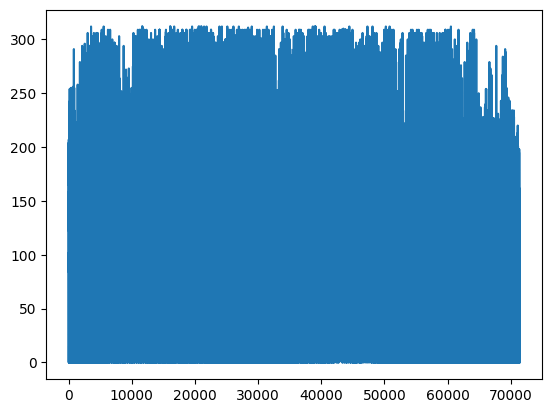

In [6]:
X['veg'].plot() # --> Standard Scaler

<Axes: >

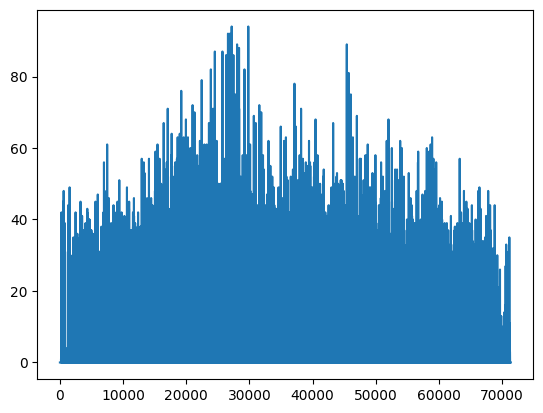

In [7]:
X['roads'].plot() # --> Standard Scaler

<Axes: >

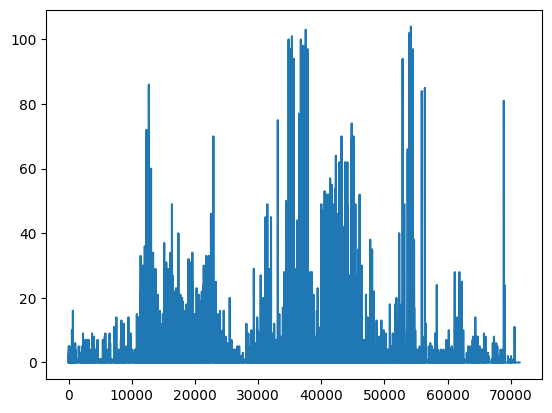

In [8]:
X['water'].plot() # --> Standard Scaler

<Axes: >

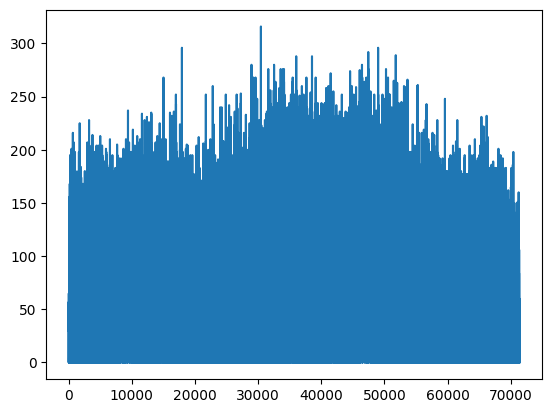

In [9]:
X['height_resid'].plot() # --> Standard Scaler

<Axes: >

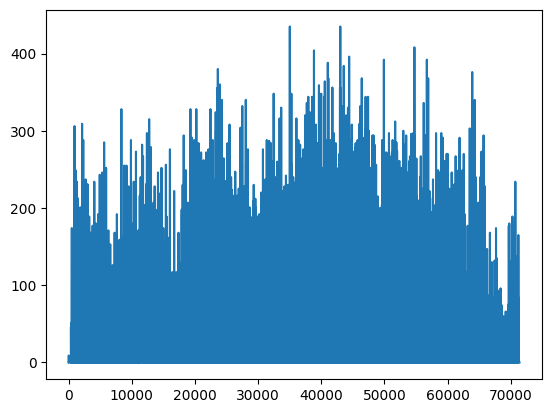

In [10]:
X['height_nonresid'].plot() # --> Standard Scaler

In [11]:
X['land_use_code'].value_counts() # --> One hot encode

11210    13534
12100    11373
31000    10522
11220     9136
14100     6880
14200     5776
11100     4513
21000     2383
50000     1711
11230     1529
23000     1046
12230      727
32000      614
12400      419
12210      306
13400      297
12220      195
12300      131
13300      101
40000       96
13100       38
11240       37
11300       16
24000        6
33000        1
Name: land_use_code, dtype: int64

In [12]:
X['land_use_area'].value_counts() # drop

1.182261e+07    1182
6.227669e+06     623
4.961632e+06     498
4.963490e+06     495
4.326415e+06     430
                ... 
1.215070e+04       1
2.105853e+04       1
4.235249e+03       1
9.257567e+03       1
1.167811e+04       1
Name: land_use_area, Length: 18353, dtype: int64

## Standardization & Encoding

In [13]:
scaler = StandardScaler()
X_drop = pd.DataFrame(X[['veg', 'roads', 'water', 'height_resid', 'height_nonresid','land_use_area', 'population']])
X_scaled = pd.DataFrame(scaler.fit_transform(X_drop))

In [14]:
X_scaled.rename(columns = {0:'veg', 1: 'roads', 2:'water', 3:'height_resid', 4:'height_nonresid', 5:'land_use_area', 6:'population'}, inplace = True)

In [15]:
# Select the column to one-hot encode
col_to_encode = df[['land_use_code']]

# Create a OneHotEncoder object
encoder = OneHotEncoder()

# Fit the encoder to the data and transform the data
col_encoded = encoder.fit_transform(col_to_encode)

# Convert the sparse matrix to a dense array and create a new DataFrame
col_encoded_df = pd.DataFrame.sparse.from_spmatrix(col_encoded, columns=encoder.get_feature_names_out(['land_use_code']))

# Concatenate the encoded column with the original DataFrame
X_encoded = pd.concat([X_scaled, col_encoded_df], axis=1)

In [88]:
# Variables to use below
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y, test_size=0.2, random_state=42)

## Baseline Model

In [91]:
temp = y_test.median()
temp_mean = y_test.mean()

In [98]:
data = pd.Series(temp_mean, index=range(len(y_test)))

In [99]:
r2 = r2_score(y_test, data)
print('R-squared:', r2)

R-squared: 0.0


## Linear Regression Model

In [17]:
# Create a linear regression object
model = LinearRegression()

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
predictions = model.predict(X_test)

# Evaluate the model performance on the testing data
score = model.score(X_test, y_test)
print('R-squared:', score)

R-squared: 0.08617283005409826


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [18]:
# Print the model coefficients
print('Coefficients:', model.coef_)

# Print the model intercept
print('Intercept:', model.intercept_)

Coefficients: [ 0.16632965  0.03943533  0.06966809  0.03085154 -0.02432379 -0.06916102
 -0.06323304  0.22464915 -0.2272031  -0.2895292  -0.15291433 -0.21864699
 -0.23525099 -0.201853   -0.5519782  -0.25205777 -0.04550304 -0.27341501
 -0.42668155 -0.1454627  -0.53478987 -0.00846795  0.80297672  0.08199235
 -0.06829508  0.21465017 -0.13354382 -0.04059579  0.21140509  1.64206473
  0.28365708  0.34479308]
Intercept: -0.710872602698784


In [19]:
columns = ['veg', 'roads', 'water', 'height_resid', 'height_nonresid', 'land_use_area', 'population']
data = pd.concat([X_scaled, y], axis=1)

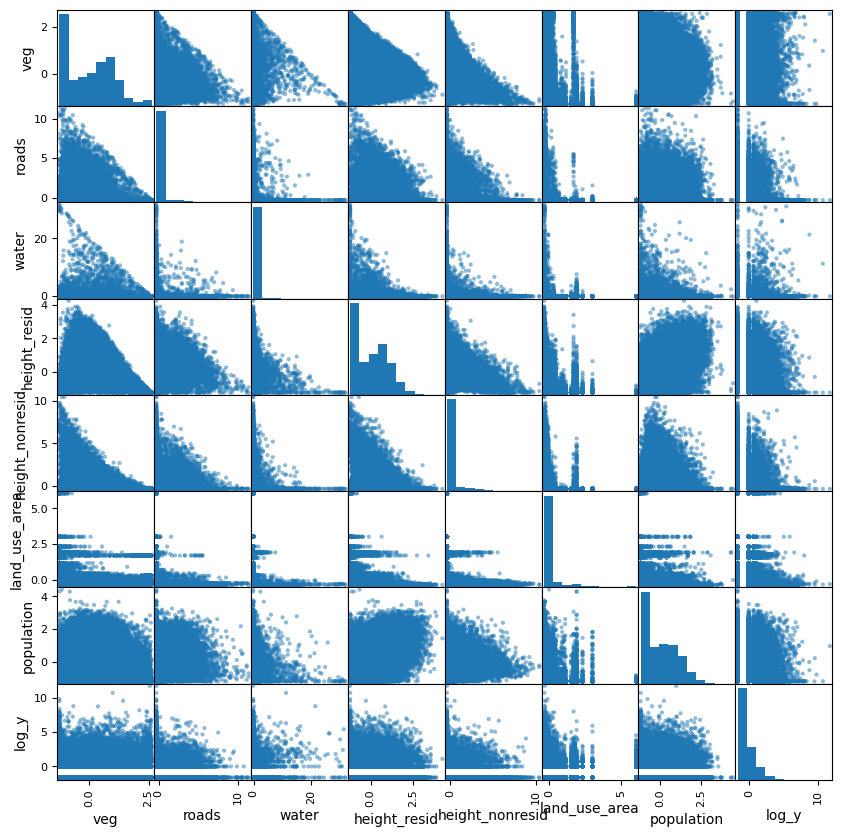

In [20]:
pd.plotting.scatter_matrix(data, figsize=(10,10))
plt.show()

In [21]:
cv_results = cross_validate(model, X_encoded, y, cv=5, 
                            scoring=['max_error',
                                     'r2', 
                                     'neg_mean_absolute_error',
                                     'neg_mean_squared_error']
                           )
pd.DataFrame(cv_results)

/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse column

,fit_time,score_time,test_max_error,test_r2,test_neg_mean_absolute_error,test_neg_mean_squared_error
0,0.155415,0.008464,-10.080499,0.010754,-0.978024,-1.324732
1,0.150466,0.008413,-11.229262,0.023581,-1.082129,-1.858543
2,0.153970,0.008244,-8.119907,0.014107,-1.230561,-2.465202
3,0.151775,0.008394,-9.542635,0.066126,-1.071498,-1.686530
4,0.140996,0.008049,-8.967989,0.007796,-0.982614,-1.418011


In [22]:
# Calculate the correlation coefficients
corr_coef = X_encoded.corrwith(y)

# Print the correlation coefficients
print(corr_coef)

veg                    0.112960
roads                  0.012609
water                  0.070612
height_resid          -0.004113
height_nonresid       -0.058498
land_use_area         -0.081895
population            -0.012366
land_use_code_11100    0.049893
land_use_code_11210   -0.042103
land_use_code_11220   -0.041564
land_use_code_11230   -0.001189
land_use_code_11240   -0.003556
land_use_code_11300   -0.004764
land_use_code_12100   -0.065360
land_use_code_12210   -0.020083
land_use_code_12220   -0.005762
land_use_code_12230    0.001519
land_use_code_12300   -0.014005
land_use_code_12400   -0.036926
land_use_code_13100   -0.004412
land_use_code_13300   -0.013663
land_use_code_13400   -0.002381
land_use_code_14100    0.215043
land_use_code_14200    0.044034
land_use_code_21000   -0.032984
land_use_code_23000    0.011993
land_use_code_24000    0.001522
land_use_code_31000   -0.090409
land_use_code_32000    0.016259
land_use_code_33000    0.003926
land_use_code_40000    0.005802
land_use

In [23]:
corr_coef = corr_coef.sort_values()

<Axes: >

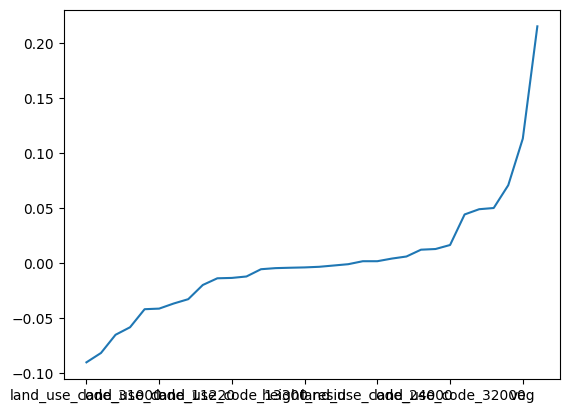

In [24]:
corr_coef.plot()

## SVR Model

In [25]:
from sklearn.svm import SVR

In [43]:
indices = X_train.index.intersection(y.index)
sample_indices = np.random.choice(indices, size=25000, replace=False)
sample_X = X_train.loc[sample_indices]
sample_y = y.loc[sample_indices]

In [44]:
sample_X.shape

(25000, 32)

In [45]:
sample_y.shape

(25000,)

In [46]:
model = SVR(kernel='rbf', C=1.0, epsilon=0.1)

# Fit the model to the training data
model.fit(sample_X, sample_y)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model performance on the testing data
score = model.score(X_test, y_test)

/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [47]:
print('R-squared:', score)

R-squared: -0.0853658880171948


## Catboost

In [50]:
! pip install catboost

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 5.6 MB/s eta 0:00:0000:0100:01m
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.0/47.0 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.2/15.2 MB 14.1 MB/s eta 0:00:0000:0100:01


In [51]:
from catboost import CatBoostRegressor

In [52]:

# Create a CatBoostRegressor object
model = CatBoostRegressor(iterations=100, learning_rate=0.1, loss_function='RMSE')

# Fit the model to the training data
model.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = model.predict(X_test)

# Evaluate the model performance on the testing data
score = model.score(X_test, y_test)
print('R-squared:', score)

0:	learn: 1.3457923	total: 58.8ms	remaining: 5.82s
1:	learn: 1.3382289	total: 64.9ms	remaining: 3.18s
2:	learn: 1.3313508	total: 70.9ms	remaining: 2.29s
3:	learn: 1.3259927	total: 78.2ms	remaining: 1.88s
4:	learn: 1.3205904	total: 82.4ms	remaining: 1.56s
5:	learn: 1.3160450	total: 86.1ms	remaining: 1.35s
6:	learn: 1.3119676	total: 91ms	remaining: 1.21s
7:	learn: 1.3087180	total: 95.4ms	remaining: 1.1s
8:	learn: 1.3061068	total: 98.6ms	remaining: 997ms
9:	learn: 1.3040856	total: 103ms	remaining: 926ms
10:	learn: 1.3020195	total: 106ms	remaining: 857ms
11:	learn: 1.3002391	total: 109ms	remaining: 802ms
12:	learn: 1.2989173	total: 112ms	remaining: 753ms
13:	learn: 1.2973665	total: 116ms	remaining: 711ms
14:	learn: 1.2961695	total: 119ms	remaining: 673ms
15:	learn: 1.2950502	total: 122ms	remaining: 639ms
16:	learn: 1.2941414	total: 125ms	remaining: 609ms
17:	learn: 1.2932516	total: 128ms	remaining: 582ms
18:	learn: 1.2922386	total: 131ms	remaining: 557ms
19:	learn: 1.2916396	total: 133ms	r

In [58]:
param_grid = {
    'iterations': [200, 250, 300],
    'learning_rate': [0.1],
    'depth': [8, 10, 12],
}

# Perform the grid search
grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

0:	learn: 1.3425477	total: 4.64ms	remaining: 923ms
1:	learn: 1.3337814	total: 9.85ms	remaining: 975ms
2:	learn: 1.3261843	total: 15.4ms	remaining: 1.01s
3:	learn: 1.3198676	total: 21.6ms	remaining: 1.06s
4:	learn: 1.3143584	total: 30ms	remaining: 1.17s
5:	learn: 1.3094939	total: 36.2ms	remaining: 1.17s
6:	learn: 1.3054398	total: 42.3ms	remaining: 1.17s
7:	learn: 1.3024849	total: 49.4ms	remaining: 1.19s
8:	learn: 1.2994984	total: 56.3ms	remaining: 1.19s
9:	learn: 1.2966096	total: 63.5ms	remaining: 1.21s
10:	learn: 1.2942573	total: 73.1ms	remaining: 1.25s
11:	learn: 1.2922258	total: 78.6ms	remaining: 1.23s
12:	learn: 1.2905789	total: 85.1ms	remaining: 1.22s
13:	learn: 1.2888675	total: 93.5ms	remaining: 1.24s
14:	learn: 1.2870818	total: 100ms	remaining: 1.24s
15:	learn: 1.2857421	total: 105ms	remaining: 1.21s
16:	learn: 1.2847349	total: 110ms	remaining: 1.18s
17:	learn: 1.2837974	total: 115ms	remaining: 1.16s
18:	learn: 1.2829679	total: 120ms	remaining: 1.14s
19:	learn: 1.2821257	total: 1

185:	learn: 1.2303484	total: 790ms	remaining: 59.5ms
186:	learn: 1.2300018	total: 794ms	remaining: 55.2ms
187:	learn: 1.2297088	total: 797ms	remaining: 50.9ms
188:	learn: 1.2295907	total: 801ms	remaining: 46.6ms
189:	learn: 1.2292650	total: 804ms	remaining: 42.3ms
190:	learn: 1.2289437	total: 808ms	remaining: 38.1ms
191:	learn: 1.2286103	total: 812ms	remaining: 33.8ms
192:	learn: 1.2284518	total: 816ms	remaining: 29.6ms
193:	learn: 1.2283298	total: 822ms	remaining: 25.4ms
194:	learn: 1.2282590	total: 825ms	remaining: 21.2ms
195:	learn: 1.2282305	total: 828ms	remaining: 16.9ms
196:	learn: 1.2280190	total: 832ms	remaining: 12.7ms
197:	learn: 1.2276927	total: 838ms	remaining: 8.46ms
198:	learn: 1.2274065	total: 842ms	remaining: 4.23ms
199:	learn: 1.2273914	total: 845ms	remaining: 0us
0:	learn: 1.3477631	total: 3.68ms	remaining: 732ms
1:	learn: 1.3389594	total: 7.21ms	remaining: 714ms
2:	learn: 1.3310058	total: 10.7ms	remaining: 702ms
3:	learn: 1.3251271	total: 14.8ms	remaining: 725ms
4:	l

194:	learn: 1.2372558	total: 873ms	remaining: 22.4ms
195:	learn: 1.2370432	total: 876ms	remaining: 17.9ms
196:	learn: 1.2368884	total: 880ms	remaining: 13.4ms
197:	learn: 1.2368775	total: 882ms	remaining: 8.91ms
198:	learn: 1.2367755	total: 886ms	remaining: 4.45ms
199:	learn: 1.2365824	total: 890ms	remaining: 0us
0:	learn: 1.3457449	total: 3.4ms	remaining: 677ms
1:	learn: 1.3376040	total: 7.29ms	remaining: 722ms
2:	learn: 1.3302647	total: 10.9ms	remaining: 718ms
3:	learn: 1.3249229	total: 14.3ms	remaining: 703ms
4:	learn: 1.3190333	total: 17.7ms	remaining: 689ms
5:	learn: 1.3146955	total: 21ms	remaining: 680ms
6:	learn: 1.3107933	total: 24.6ms	remaining: 678ms
7:	learn: 1.3072734	total: 28.5ms	remaining: 684ms
8:	learn: 1.3040901	total: 32.1ms	remaining: 681ms
9:	learn: 1.3014193	total: 35.6ms	remaining: 677ms
10:	learn: 1.2989813	total: 39ms	remaining: 670ms
11:	learn: 1.2969966	total: 42.5ms	remaining: 666ms
12:	learn: 1.2956196	total: 45.9ms	remaining: 660ms
13:	learn: 1.2943284	tot

181:	learn: 1.2355988	total: 705ms	remaining: 69.8ms
182:	learn: 1.2354032	total: 712ms	remaining: 66.1ms
183:	learn: 1.2353772	total: 717ms	remaining: 62.4ms
184:	learn: 1.2351959	total: 723ms	remaining: 58.7ms
185:	learn: 1.2349431	total: 729ms	remaining: 54.9ms
186:	learn: 1.2345837	total: 735ms	remaining: 51.1ms
187:	learn: 1.2343232	total: 741ms	remaining: 47.3ms
188:	learn: 1.2342047	total: 747ms	remaining: 43.5ms
189:	learn: 1.2340682	total: 752ms	remaining: 39.6ms
190:	learn: 1.2339026	total: 756ms	remaining: 35.6ms
191:	learn: 1.2335230	total: 761ms	remaining: 31.7ms
192:	learn: 1.2333548	total: 765ms	remaining: 27.8ms
193:	learn: 1.2331746	total: 770ms	remaining: 23.8ms
194:	learn: 1.2330114	total: 774ms	remaining: 19.8ms
195:	learn: 1.2326986	total: 779ms	remaining: 15.9ms
196:	learn: 1.2324688	total: 783ms	remaining: 11.9ms
197:	learn: 1.2320030	total: 787ms	remaining: 7.95ms
198:	learn: 1.2317687	total: 791ms	remaining: 3.97ms
199:	learn: 1.2315773	total: 794ms	remaining: 

160:	learn: 1.2419306	total: 634ms	remaining: 154ms
161:	learn: 1.2417125	total: 638ms	remaining: 150ms
162:	learn: 1.2414416	total: 643ms	remaining: 146ms
163:	learn: 1.2411620	total: 647ms	remaining: 142ms
164:	learn: 1.2408758	total: 650ms	remaining: 138ms
165:	learn: 1.2406987	total: 654ms	remaining: 134ms
166:	learn: 1.2405581	total: 659ms	remaining: 130ms
167:	learn: 1.2402334	total: 663ms	remaining: 126ms
168:	learn: 1.2398995	total: 668ms	remaining: 122ms
169:	learn: 1.2396574	total: 672ms	remaining: 119ms
170:	learn: 1.2390469	total: 676ms	remaining: 115ms
171:	learn: 1.2382713	total: 682ms	remaining: 111ms
172:	learn: 1.2380616	total: 687ms	remaining: 107ms
173:	learn: 1.2378045	total: 692ms	remaining: 103ms
174:	learn: 1.2373679	total: 697ms	remaining: 99.6ms
175:	learn: 1.2370867	total: 702ms	remaining: 95.8ms
176:	learn: 1.2369211	total: 707ms	remaining: 91.9ms
177:	learn: 1.2366249	total: 712ms	remaining: 88ms
178:	learn: 1.2363018	total: 721ms	remaining: 84.6ms
179:	lear

131:	learn: 1.2448433	total: 509ms	remaining: 262ms
132:	learn: 1.2445677	total: 513ms	remaining: 258ms
133:	learn: 1.2441332	total: 517ms	remaining: 255ms
134:	learn: 1.2438365	total: 521ms	remaining: 251ms
135:	learn: 1.2435815	total: 524ms	remaining: 247ms
136:	learn: 1.2430287	total: 528ms	remaining: 243ms
137:	learn: 1.2428260	total: 532ms	remaining: 239ms
138:	learn: 1.2428065	total: 536ms	remaining: 235ms
139:	learn: 1.2427921	total: 539ms	remaining: 231ms
140:	learn: 1.2423946	total: 543ms	remaining: 227ms
141:	learn: 1.2423804	total: 546ms	remaining: 223ms
142:	learn: 1.2423675	total: 549ms	remaining: 219ms
143:	learn: 1.2420213	total: 554ms	remaining: 216ms
144:	learn: 1.2417170	total: 559ms	remaining: 212ms
145:	learn: 1.2411258	total: 562ms	remaining: 208ms
146:	learn: 1.2408445	total: 566ms	remaining: 204ms
147:	learn: 1.2406494	total: 570ms	remaining: 200ms
148:	learn: 1.2402195	total: 574ms	remaining: 196ms
149:	learn: 1.2402073	total: 577ms	remaining: 192ms
150:	learn: 

124:	learn: 1.2471279	total: 486ms	remaining: 486ms
125:	learn: 1.2466351	total: 489ms	remaining: 482ms
126:	learn: 1.2463322	total: 493ms	remaining: 478ms
127:	learn: 1.2460013	total: 497ms	remaining: 473ms
128:	learn: 1.2456851	total: 501ms	remaining: 469ms
129:	learn: 1.2454783	total: 504ms	remaining: 466ms
130:	learn: 1.2454048	total: 508ms	remaining: 462ms
131:	learn: 1.2451529	total: 512ms	remaining: 458ms
132:	learn: 1.2449352	total: 517ms	remaining: 455ms
133:	learn: 1.2446744	total: 520ms	remaining: 450ms
134:	learn: 1.2440114	total: 524ms	remaining: 446ms
135:	learn: 1.2438074	total: 527ms	remaining: 442ms
136:	learn: 1.2437633	total: 530ms	remaining: 438ms
137:	learn: 1.2434209	total: 535ms	remaining: 434ms
138:	learn: 1.2431528	total: 539ms	remaining: 430ms
139:	learn: 1.2423117	total: 542ms	remaining: 426ms
140:	learn: 1.2419555	total: 546ms	remaining: 422ms
141:	learn: 1.2417986	total: 549ms	remaining: 418ms
142:	learn: 1.2415941	total: 553ms	remaining: 413ms
143:	learn: 

72:	learn: 1.2683010	total: 263ms	remaining: 637ms
73:	learn: 1.2679396	total: 267ms	remaining: 634ms
74:	learn: 1.2676691	total: 270ms	remaining: 631ms
75:	learn: 1.2675440	total: 274ms	remaining: 627ms
76:	learn: 1.2673856	total: 277ms	remaining: 623ms
77:	learn: 1.2670802	total: 281ms	remaining: 620ms
78:	learn: 1.2669566	total: 285ms	remaining: 616ms
79:	learn: 1.2664724	total: 288ms	remaining: 613ms
80:	learn: 1.2661701	total: 293ms	remaining: 611ms
81:	learn: 1.2659852	total: 297ms	remaining: 608ms
82:	learn: 1.2658844	total: 300ms	remaining: 604ms
83:	learn: 1.2656185	total: 304ms	remaining: 600ms
84:	learn: 1.2653801	total: 307ms	remaining: 596ms
85:	learn: 1.2651650	total: 312ms	remaining: 595ms
86:	learn: 1.2649494	total: 316ms	remaining: 593ms
87:	learn: 1.2647549	total: 320ms	remaining: 589ms
88:	learn: 1.2646012	total: 324ms	remaining: 586ms
89:	learn: 1.2644830	total: 328ms	remaining: 583ms
90:	learn: 1.2643068	total: 332ms	remaining: 580ms
91:	learn: 1.2640090	total: 335

236:	learn: 1.2278606	total: 848ms	remaining: 46.5ms
237:	learn: 1.2276432	total: 853ms	remaining: 43ms
238:	learn: 1.2273443	total: 857ms	remaining: 39.4ms
239:	learn: 1.2271470	total: 861ms	remaining: 35.9ms
240:	learn: 1.2269603	total: 864ms	remaining: 32.3ms
241:	learn: 1.2268213	total: 868ms	remaining: 28.7ms
242:	learn: 1.2262758	total: 872ms	remaining: 25.1ms
243:	learn: 1.2259892	total: 876ms	remaining: 21.5ms
244:	learn: 1.2256682	total: 882ms	remaining: 18ms
245:	learn: 1.2253725	total: 887ms	remaining: 14.4ms
246:	learn: 1.2251914	total: 891ms	remaining: 10.8ms
247:	learn: 1.2250728	total: 895ms	remaining: 7.22ms
248:	learn: 1.2249462	total: 899ms	remaining: 3.61ms
249:	learn: 1.2247872	total: 904ms	remaining: 0us
0:	learn: 1.3457449	total: 4.51ms	remaining: 1.12s
1:	learn: 1.3376040	total: 8.69ms	remaining: 1.08s
2:	learn: 1.3302647	total: 13.2ms	remaining: 1.09s
3:	learn: 1.3249229	total: 17.5ms	remaining: 1.08s
4:	learn: 1.3190333	total: 21.3ms	remaining: 1.04s
5:	learn: 

176:	learn: 1.2370874	total: 674ms	remaining: 278ms
177:	learn: 1.2367456	total: 678ms	remaining: 274ms
178:	learn: 1.2365798	total: 682ms	remaining: 270ms
179:	learn: 1.2362591	total: 685ms	remaining: 267ms
180:	learn: 1.2359990	total: 690ms	remaining: 263ms
181:	learn: 1.2355988	total: 695ms	remaining: 260ms
182:	learn: 1.2354032	total: 700ms	remaining: 256ms
183:	learn: 1.2353772	total: 706ms	remaining: 253ms
184:	learn: 1.2351959	total: 711ms	remaining: 250ms
185:	learn: 1.2349431	total: 716ms	remaining: 246ms
186:	learn: 1.2345837	total: 721ms	remaining: 243ms
187:	learn: 1.2343232	total: 725ms	remaining: 239ms
188:	learn: 1.2342047	total: 729ms	remaining: 235ms
189:	learn: 1.2340682	total: 733ms	remaining: 232ms
190:	learn: 1.2339026	total: 738ms	remaining: 228ms
191:	learn: 1.2335230	total: 742ms	remaining: 224ms
192:	learn: 1.2333548	total: 746ms	remaining: 220ms
193:	learn: 1.2331746	total: 751ms	remaining: 217ms
194:	learn: 1.2330114	total: 755ms	remaining: 213ms
195:	learn: 

125:	learn: 1.2512180	total: 445ms	remaining: 438ms
126:	learn: 1.2510454	total: 449ms	remaining: 435ms
127:	learn: 1.2507086	total: 453ms	remaining: 431ms
128:	learn: 1.2504626	total: 456ms	remaining: 428ms
129:	learn: 1.2501754	total: 460ms	remaining: 424ms
130:	learn: 1.2497942	total: 463ms	remaining: 421ms
131:	learn: 1.2495780	total: 467ms	remaining: 418ms
132:	learn: 1.2495317	total: 471ms	remaining: 414ms
133:	learn: 1.2486775	total: 474ms	remaining: 411ms
134:	learn: 1.2483978	total: 479ms	remaining: 408ms
135:	learn: 1.2483599	total: 482ms	remaining: 404ms
136:	learn: 1.2481845	total: 485ms	remaining: 400ms
137:	learn: 1.2479160	total: 490ms	remaining: 398ms
138:	learn: 1.2477622	total: 494ms	remaining: 394ms
139:	learn: 1.2475983	total: 497ms	remaining: 391ms
140:	learn: 1.2473677	total: 501ms	remaining: 387ms
141:	learn: 1.2471717	total: 505ms	remaining: 384ms
142:	learn: 1.2466088	total: 508ms	remaining: 380ms
143:	learn: 1.2462527	total: 512ms	remaining: 377ms
144:	learn: 

79:	learn: 1.2581724	total: 281ms	remaining: 596ms
80:	learn: 1.2578845	total: 285ms	remaining: 594ms
81:	learn: 1.2577303	total: 289ms	remaining: 592ms
82:	learn: 1.2574636	total: 293ms	remaining: 589ms
83:	learn: 1.2568547	total: 296ms	remaining: 586ms
84:	learn: 1.2565981	total: 300ms	remaining: 583ms
85:	learn: 1.2563175	total: 304ms	remaining: 580ms
86:	learn: 1.2561870	total: 308ms	remaining: 577ms
87:	learn: 1.2560106	total: 312ms	remaining: 574ms
88:	learn: 1.2556877	total: 316ms	remaining: 572ms
89:	learn: 1.2555524	total: 320ms	remaining: 569ms
90:	learn: 1.2553497	total: 324ms	remaining: 566ms
91:	learn: 1.2552098	total: 327ms	remaining: 562ms
92:	learn: 1.2550873	total: 332ms	remaining: 561ms
93:	learn: 1.2549707	total: 336ms	remaining: 558ms
94:	learn: 1.2548463	total: 339ms	remaining: 554ms
95:	learn: 1.2546342	total: 343ms	remaining: 550ms
96:	learn: 1.2545214	total: 347ms	remaining: 547ms
97:	learn: 1.2543173	total: 350ms	remaining: 543ms
98:	learn: 1.2537991	total: 353

246:	learn: 1.2154429	total: 868ms	remaining: 10.5ms
247:	learn: 1.2152737	total: 871ms	remaining: 7.03ms
248:	learn: 1.2150252	total: 876ms	remaining: 3.52ms
249:	learn: 1.2148456	total: 879ms	remaining: 0us
0:	learn: 1.3425477	total: 3.86ms	remaining: 1.15s
1:	learn: 1.3337814	total: 7.44ms	remaining: 1.11s
2:	learn: 1.3261843	total: 11ms	remaining: 1.09s
3:	learn: 1.3198676	total: 14.4ms	remaining: 1.07s
4:	learn: 1.3143584	total: 18.7ms	remaining: 1.1s
5:	learn: 1.3094939	total: 22.4ms	remaining: 1.1s
6:	learn: 1.3054398	total: 26.3ms	remaining: 1.1s
7:	learn: 1.3024849	total: 30ms	remaining: 1.09s
8:	learn: 1.2994984	total: 36ms	remaining: 1.16s
9:	learn: 1.2966096	total: 41ms	remaining: 1.19s
10:	learn: 1.2942573	total: 46.1ms	remaining: 1.21s
11:	learn: 1.2922258	total: 50.8ms	remaining: 1.22s
12:	learn: 1.2905789	total: 55.3ms	remaining: 1.22s
13:	learn: 1.2888675	total: 59.4ms	remaining: 1.21s
14:	learn: 1.2870818	total: 63.4ms	remaining: 1.2s
15:	learn: 1.2857421	total: 67.6m

174:	learn: 1.2327120	total: 712ms	remaining: 509ms
175:	learn: 1.2324934	total: 716ms	remaining: 505ms
176:	learn: 1.2323703	total: 720ms	remaining: 500ms
177:	learn: 1.2321990	total: 724ms	remaining: 496ms
178:	learn: 1.2319550	total: 728ms	remaining: 492ms
179:	learn: 1.2317612	total: 732ms	remaining: 488ms
180:	learn: 1.2314789	total: 736ms	remaining: 484ms
181:	learn: 1.2312406	total: 740ms	remaining: 480ms
182:	learn: 1.2310904	total: 744ms	remaining: 476ms
183:	learn: 1.2308662	total: 749ms	remaining: 472ms
184:	learn: 1.2306191	total: 753ms	remaining: 468ms
185:	learn: 1.2303484	total: 756ms	remaining: 464ms
186:	learn: 1.2300018	total: 760ms	remaining: 459ms
187:	learn: 1.2297088	total: 764ms	remaining: 455ms
188:	learn: 1.2295907	total: 768ms	remaining: 451ms
189:	learn: 1.2292650	total: 772ms	remaining: 447ms
190:	learn: 1.2289437	total: 775ms	remaining: 443ms
191:	learn: 1.2286103	total: 779ms	remaining: 438ms
192:	learn: 1.2284518	total: 782ms	remaining: 434ms
193:	learn: 

54:	learn: 1.2741868	total: 221ms	remaining: 985ms
55:	learn: 1.2739220	total: 226ms	remaining: 986ms
56:	learn: 1.2735119	total: 231ms	remaining: 986ms
57:	learn: 1.2734432	total: 236ms	remaining: 985ms
58:	learn: 1.2731589	total: 241ms	remaining: 984ms
59:	learn: 1.2725748	total: 246ms	remaining: 984ms
60:	learn: 1.2724133	total: 251ms	remaining: 982ms
61:	learn: 1.2721284	total: 256ms	remaining: 985ms
62:	learn: 1.2716788	total: 261ms	remaining: 982ms
63:	learn: 1.2712982	total: 266ms	remaining: 981ms
64:	learn: 1.2710803	total: 271ms	remaining: 979ms
65:	learn: 1.2702094	total: 276ms	remaining: 980ms
66:	learn: 1.2699584	total: 281ms	remaining: 977ms
67:	learn: 1.2697984	total: 285ms	remaining: 974ms
68:	learn: 1.2695323	total: 290ms	remaining: 972ms
69:	learn: 1.2691548	total: 296ms	remaining: 971ms
70:	learn: 1.2689772	total: 301ms	remaining: 970ms
71:	learn: 1.2687132	total: 305ms	remaining: 966ms
72:	learn: 1.2683010	total: 311ms	remaining: 967ms
73:	learn: 1.2679396	total: 317

231:	learn: 1.2289962	total: 1.01s	remaining: 297ms
232:	learn: 1.2288590	total: 1.02s	remaining: 293ms
233:	learn: 1.2285781	total: 1.02s	remaining: 289ms
234:	learn: 1.2283010	total: 1.03s	remaining: 284ms
235:	learn: 1.2280412	total: 1.03s	remaining: 280ms
236:	learn: 1.2278606	total: 1.03s	remaining: 275ms
237:	learn: 1.2276432	total: 1.04s	remaining: 271ms
238:	learn: 1.2273443	total: 1.04s	remaining: 267ms
239:	learn: 1.2271470	total: 1.05s	remaining: 263ms
240:	learn: 1.2269603	total: 1.05s	remaining: 258ms
241:	learn: 1.2268213	total: 1.06s	remaining: 254ms
242:	learn: 1.2262758	total: 1.06s	remaining: 250ms
243:	learn: 1.2259892	total: 1.07s	remaining: 246ms
244:	learn: 1.2256682	total: 1.07s	remaining: 241ms
245:	learn: 1.2253725	total: 1.08s	remaining: 237ms
246:	learn: 1.2251914	total: 1.08s	remaining: 232ms
247:	learn: 1.2250728	total: 1.09s	remaining: 228ms
248:	learn: 1.2249462	total: 1.09s	remaining: 224ms
249:	learn: 1.2247872	total: 1.1s	remaining: 219ms
250:	learn: 1

103:	learn: 1.2587600	total: 442ms	remaining: 833ms
104:	learn: 1.2580627	total: 447ms	remaining: 830ms
105:	learn: 1.2575247	total: 451ms	remaining: 826ms
106:	learn: 1.2572948	total: 456ms	remaining: 822ms
107:	learn: 1.2569968	total: 460ms	remaining: 817ms
108:	learn: 1.2567487	total: 464ms	remaining: 813ms
109:	learn: 1.2564335	total: 468ms	remaining: 808ms
110:	learn: 1.2562531	total: 473ms	remaining: 806ms
111:	learn: 1.2559530	total: 477ms	remaining: 801ms
112:	learn: 1.2557342	total: 481ms	remaining: 796ms
113:	learn: 1.2555646	total: 485ms	remaining: 791ms
114:	learn: 1.2552439	total: 488ms	remaining: 786ms
115:	learn: 1.2549767	total: 492ms	remaining: 780ms
116:	learn: 1.2546665	total: 495ms	remaining: 775ms
117:	learn: 1.2541564	total: 499ms	remaining: 769ms
118:	learn: 1.2539964	total: 502ms	remaining: 764ms
119:	learn: 1.2537806	total: 506ms	remaining: 759ms
120:	learn: 1.2534568	total: 509ms	remaining: 753ms
121:	learn: 1.2532348	total: 513ms	remaining: 749ms
122:	learn: 

263:	learn: 1.2181490	total: 1.03s	remaining: 140ms
264:	learn: 1.2179845	total: 1.03s	remaining: 136ms
265:	learn: 1.2177982	total: 1.03s	remaining: 132ms
266:	learn: 1.2176351	total: 1.04s	remaining: 128ms
267:	learn: 1.2175404	total: 1.04s	remaining: 124ms
268:	learn: 1.2170895	total: 1.04s	remaining: 121ms
269:	learn: 1.2168044	total: 1.05s	remaining: 117ms
270:	learn: 1.2165615	total: 1.05s	remaining: 113ms
271:	learn: 1.2164517	total: 1.06s	remaining: 109ms
272:	learn: 1.2162056	total: 1.06s	remaining: 105ms
273:	learn: 1.2160113	total: 1.07s	remaining: 101ms
274:	learn: 1.2157449	total: 1.07s	remaining: 97.4ms
275:	learn: 1.2153878	total: 1.07s	remaining: 93.5ms
276:	learn: 1.2152162	total: 1.08s	remaining: 89.6ms
277:	learn: 1.2150223	total: 1.08s	remaining: 85.6ms
278:	learn: 1.2148730	total: 1.08s	remaining: 81.7ms
279:	learn: 1.2145364	total: 1.09s	remaining: 77.8ms
280:	learn: 1.2144573	total: 1.09s	remaining: 73.9ms
281:	learn: 1.2140914	total: 1.1s	remaining: 70ms
282:	le

157:	learn: 1.2425263	total: 595ms	remaining: 535ms
158:	learn: 1.2423224	total: 599ms	remaining: 531ms
159:	learn: 1.2420806	total: 603ms	remaining: 527ms
160:	learn: 1.2419306	total: 607ms	remaining: 524ms
161:	learn: 1.2417125	total: 611ms	remaining: 520ms
162:	learn: 1.2414416	total: 615ms	remaining: 517ms
163:	learn: 1.2411620	total: 619ms	remaining: 513ms
164:	learn: 1.2408758	total: 623ms	remaining: 510ms
165:	learn: 1.2406987	total: 628ms	remaining: 507ms
166:	learn: 1.2405581	total: 631ms	remaining: 503ms
167:	learn: 1.2402334	total: 635ms	remaining: 499ms
168:	learn: 1.2398995	total: 640ms	remaining: 496ms
169:	learn: 1.2396574	total: 644ms	remaining: 492ms
170:	learn: 1.2390469	total: 647ms	remaining: 488ms
171:	learn: 1.2382713	total: 651ms	remaining: 484ms
172:	learn: 1.2380616	total: 654ms	remaining: 480ms
173:	learn: 1.2378045	total: 658ms	remaining: 476ms
174:	learn: 1.2373679	total: 661ms	remaining: 472ms
175:	learn: 1.2370867	total: 664ms	remaining: 468ms
176:	learn: 

56:	learn: 1.2648213	total: 208ms	remaining: 885ms
57:	learn: 1.2643798	total: 212ms	remaining: 883ms
58:	learn: 1.2642446	total: 215ms	remaining: 879ms
59:	learn: 1.2638065	total: 219ms	remaining: 877ms
60:	learn: 1.2629245	total: 223ms	remaining: 873ms
61:	learn: 1.2624262	total: 227ms	remaining: 870ms
62:	learn: 1.2622484	total: 230ms	remaining: 865ms
63:	learn: 1.2621332	total: 234ms	remaining: 862ms
64:	learn: 1.2618480	total: 238ms	remaining: 860ms
65:	learn: 1.2616569	total: 243ms	remaining: 863ms
66:	learn: 1.2614900	total: 247ms	remaining: 860ms
67:	learn: 1.2612858	total: 251ms	remaining: 856ms
68:	learn: 1.2610805	total: 255ms	remaining: 853ms
69:	learn: 1.2607440	total: 259ms	remaining: 850ms
70:	learn: 1.2605002	total: 262ms	remaining: 846ms
71:	learn: 1.2602393	total: 266ms	remaining: 842ms
72:	learn: 1.2600547	total: 270ms	remaining: 839ms
73:	learn: 1.2596330	total: 273ms	remaining: 835ms
74:	learn: 1.2593504	total: 277ms	remaining: 831ms
75:	learn: 1.2590854	total: 281

266:	learn: 1.2117173	total: 990ms	remaining: 122ms
267:	learn: 1.2114072	total: 995ms	remaining: 119ms
268:	learn: 1.2112220	total: 999ms	remaining: 115ms
269:	learn: 1.2110528	total: 1s	remaining: 111ms
270:	learn: 1.2107918	total: 1.01s	remaining: 108ms
271:	learn: 1.2104419	total: 1.01s	remaining: 104ms
272:	learn: 1.2100761	total: 1.01s	remaining: 100ms
273:	learn: 1.2098697	total: 1.02s	remaining: 96.6ms
274:	learn: 1.2096198	total: 1.02s	remaining: 92.9ms
275:	learn: 1.2093564	total: 1.03s	remaining: 89.3ms
276:	learn: 1.2091690	total: 1.03s	remaining: 85.6ms
277:	learn: 1.2089590	total: 1.03s	remaining: 81.9ms
278:	learn: 1.2088439	total: 1.04s	remaining: 78.1ms
279:	learn: 1.2087098	total: 1.04s	remaining: 74.5ms
280:	learn: 1.2083508	total: 1.05s	remaining: 70.8ms
281:	learn: 1.2081807	total: 1.05s	remaining: 67ms
282:	learn: 1.2077925	total: 1.05s	remaining: 63.3ms
283:	learn: 1.2076003	total: 1.06s	remaining: 59.6ms
284:	learn: 1.2073250	total: 1.06s	remaining: 55.8ms
285:	

127:	learn: 1.2280709	total: 1.44s	remaining: 809ms
128:	learn: 1.2273788	total: 1.45s	remaining: 798ms
129:	learn: 1.2268552	total: 1.46s	remaining: 787ms
130:	learn: 1.2263857	total: 1.47s	remaining: 776ms
131:	learn: 1.2260515	total: 1.48s	remaining: 764ms
132:	learn: 1.2256197	total: 1.49s	remaining: 753ms
133:	learn: 1.2253785	total: 1.5s	remaining: 742ms
134:	learn: 1.2250191	total: 1.52s	remaining: 730ms
135:	learn: 1.2248072	total: 1.53s	remaining: 718ms
136:	learn: 1.2242889	total: 1.54s	remaining: 707ms
137:	learn: 1.2236189	total: 1.55s	remaining: 695ms
138:	learn: 1.2232316	total: 1.56s	remaining: 683ms
139:	learn: 1.2231687	total: 1.57s	remaining: 671ms
140:	learn: 1.2228006	total: 1.58s	remaining: 660ms
141:	learn: 1.2225913	total: 1.59s	remaining: 648ms
142:	learn: 1.2222268	total: 1.59s	remaining: 636ms
143:	learn: 1.2221888	total: 1.6s	remaining: 622ms
144:	learn: 1.2217272	total: 1.61s	remaining: 610ms
145:	learn: 1.2214442	total: 1.62s	remaining: 599ms
146:	learn: 1.

96:	learn: 1.2472614	total: 1.04s	remaining: 1.1s
97:	learn: 1.2468844	total: 1.05s	remaining: 1.09s
98:	learn: 1.2466241	total: 1.06s	remaining: 1.08s
99:	learn: 1.2464495	total: 1.07s	remaining: 1.07s
100:	learn: 1.2462237	total: 1.09s	remaining: 1.07s
101:	learn: 1.2457992	total: 1.1s	remaining: 1.05s
102:	learn: 1.2455390	total: 1.11s	remaining: 1.04s
103:	learn: 1.2451932	total: 1.12s	remaining: 1.03s
104:	learn: 1.2448720	total: 1.13s	remaining: 1.02s
105:	learn: 1.2444731	total: 1.14s	remaining: 1.01s
106:	learn: 1.2442892	total: 1.15s	remaining: 1s
107:	learn: 1.2441581	total: 1.16s	remaining: 992ms
108:	learn: 1.2437732	total: 1.18s	remaining: 981ms
109:	learn: 1.2436166	total: 1.19s	remaining: 970ms
110:	learn: 1.2432208	total: 1.2s	remaining: 959ms
111:	learn: 1.2429333	total: 1.21s	remaining: 948ms
112:	learn: 1.2428112	total: 1.22s	remaining: 936ms
113:	learn: 1.2424358	total: 1.23s	remaining: 925ms
114:	learn: 1.2416458	total: 1.24s	remaining: 913ms
115:	learn: 1.2412937	

63:	learn: 1.2571982	total: 662ms	remaining: 1.41s
64:	learn: 1.2566489	total: 673ms	remaining: 1.4s
65:	learn: 1.2563192	total: 683ms	remaining: 1.39s
66:	learn: 1.2553868	total: 694ms	remaining: 1.38s
67:	learn: 1.2549808	total: 705ms	remaining: 1.37s
68:	learn: 1.2545520	total: 715ms	remaining: 1.36s
69:	learn: 1.2542690	total: 726ms	remaining: 1.35s
70:	learn: 1.2539628	total: 737ms	remaining: 1.34s
71:	learn: 1.2536332	total: 748ms	remaining: 1.33s
72:	learn: 1.2532324	total: 758ms	remaining: 1.32s
73:	learn: 1.2528820	total: 768ms	remaining: 1.31s
74:	learn: 1.2523163	total: 779ms	remaining: 1.3s
75:	learn: 1.2522862	total: 781ms	remaining: 1.27s
76:	learn: 1.2520580	total: 791ms	remaining: 1.26s
77:	learn: 1.2519398	total: 801ms	remaining: 1.25s
78:	learn: 1.2515806	total: 811ms	remaining: 1.24s
79:	learn: 1.2512370	total: 821ms	remaining: 1.23s
80:	learn: 1.2510511	total: 830ms	remaining: 1.22s
81:	learn: 1.2506352	total: 840ms	remaining: 1.21s
82:	learn: 1.2502969	total: 849ms

37:	learn: 1.2680293	total: 414ms	remaining: 1.76s
38:	learn: 1.2670706	total: 424ms	remaining: 1.75s
39:	learn: 1.2663452	total: 434ms	remaining: 1.74s
40:	learn: 1.2657094	total: 445ms	remaining: 1.73s
41:	learn: 1.2651324	total: 457ms	remaining: 1.72s
42:	learn: 1.2647736	total: 468ms	remaining: 1.71s
43:	learn: 1.2644920	total: 479ms	remaining: 1.7s
44:	learn: 1.2641473	total: 489ms	remaining: 1.69s
45:	learn: 1.2638412	total: 500ms	remaining: 1.67s
46:	learn: 1.2634018	total: 510ms	remaining: 1.66s
47:	learn: 1.2628788	total: 521ms	remaining: 1.65s
48:	learn: 1.2620693	total: 531ms	remaining: 1.64s
49:	learn: 1.2614061	total: 541ms	remaining: 1.62s
50:	learn: 1.2610682	total: 551ms	remaining: 1.61s
51:	learn: 1.2606351	total: 562ms	remaining: 1.6s
52:	learn: 1.2602261	total: 572ms	remaining: 1.59s
53:	learn: 1.2596682	total: 582ms	remaining: 1.57s
54:	learn: 1.2593376	total: 591ms	remaining: 1.56s
55:	learn: 1.2590818	total: 601ms	remaining: 1.54s
56:	learn: 1.2586611	total: 611ms

7:	learn: 1.2988322	total: 80.2ms	remaining: 1.92s
8:	learn: 1.2954073	total: 91.2ms	remaining: 1.93s
9:	learn: 1.2921363	total: 102ms	remaining: 1.95s
10:	learn: 1.2895765	total: 115ms	remaining: 1.97s
11:	learn: 1.2870045	total: 127ms	remaining: 1.99s
12:	learn: 1.2852229	total: 138ms	remaining: 1.98s
13:	learn: 1.2833670	total: 148ms	remaining: 1.97s
14:	learn: 1.2814976	total: 158ms	remaining: 1.95s
15:	learn: 1.2798185	total: 169ms	remaining: 1.94s
16:	learn: 1.2784999	total: 179ms	remaining: 1.93s
17:	learn: 1.2774581	total: 189ms	remaining: 1.91s
18:	learn: 1.2759894	total: 199ms	remaining: 1.9s
19:	learn: 1.2752132	total: 209ms	remaining: 1.88s
20:	learn: 1.2742230	total: 219ms	remaining: 1.87s
21:	learn: 1.2734707	total: 229ms	remaining: 1.85s
22:	learn: 1.2723560	total: 239ms	remaining: 1.84s
23:	learn: 1.2714341	total: 249ms	remaining: 1.82s
24:	learn: 1.2705739	total: 259ms	remaining: 1.81s
25:	learn: 1.2700282	total: 269ms	remaining: 1.8s
26:	learn: 1.2691094	total: 279ms	

179:	learn: 1.2078859	total: 1.9s	remaining: 212ms
180:	learn: 1.2074373	total: 1.92s	remaining: 201ms
181:	learn: 1.2070524	total: 1.93s	remaining: 191ms
182:	learn: 1.2067111	total: 1.95s	remaining: 181ms
183:	learn: 1.2063976	total: 1.96s	remaining: 171ms
184:	learn: 1.2059913	total: 1.97s	remaining: 160ms
185:	learn: 1.2054899	total: 1.99s	remaining: 149ms
186:	learn: 1.2054403	total: 2s	remaining: 139ms
187:	learn: 1.2050661	total: 2.01s	remaining: 128ms
188:	learn: 1.2046598	total: 2.02s	remaining: 118ms
189:	learn: 1.2039990	total: 2.03s	remaining: 107ms
190:	learn: 1.2036143	total: 2.04s	remaining: 96.4ms
191:	learn: 1.2035031	total: 2.06s	remaining: 85.7ms
192:	learn: 1.2029789	total: 2.07s	remaining: 75ms
193:	learn: 1.2026076	total: 2.08s	remaining: 64.3ms
194:	learn: 1.2023453	total: 2.09s	remaining: 53.6ms
195:	learn: 1.2020208	total: 2.1s	remaining: 42.9ms
196:	learn: 1.2016779	total: 2.11s	remaining: 32.2ms
197:	learn: 1.2013082	total: 2.13s	remaining: 21.5ms
198:	learn:

139:	learn: 1.2231687	total: 1.51s	remaining: 1.19s
140:	learn: 1.2228006	total: 1.52s	remaining: 1.18s
141:	learn: 1.2225913	total: 1.53s	remaining: 1.17s
142:	learn: 1.2222268	total: 1.55s	remaining: 1.16s
143:	learn: 1.2221888	total: 1.55s	remaining: 1.14s
144:	learn: 1.2217272	total: 1.56s	remaining: 1.13s
145:	learn: 1.2214442	total: 1.57s	remaining: 1.12s
146:	learn: 1.2209211	total: 1.58s	remaining: 1.11s
147:	learn: 1.2206620	total: 1.59s	remaining: 1.1s
148:	learn: 1.2199419	total: 1.6s	remaining: 1.09s
149:	learn: 1.2195254	total: 1.61s	remaining: 1.07s
150:	learn: 1.2187816	total: 1.62s	remaining: 1.06s
151:	learn: 1.2185372	total: 1.63s	remaining: 1.05s
152:	learn: 1.2182198	total: 1.64s	remaining: 1.04s
153:	learn: 1.2178545	total: 1.65s	remaining: 1.03s
154:	learn: 1.2174975	total: 1.66s	remaining: 1.02s
155:	learn: 1.2168253	total: 1.67s	remaining: 1.01s
156:	learn: 1.2163196	total: 1.68s	remaining: 997ms
157:	learn: 1.2159483	total: 1.69s	remaining: 986ms
158:	learn: 1.

60:	learn: 1.2603105	total: 627ms	remaining: 1.94s
61:	learn: 1.2599670	total: 637ms	remaining: 1.93s
62:	learn: 1.2594645	total: 649ms	remaining: 1.93s
63:	learn: 1.2589164	total: 660ms	remaining: 1.92s
64:	learn: 1.2586979	total: 671ms	remaining: 1.91s
65:	learn: 1.2583396	total: 683ms	remaining: 1.9s
66:	learn: 1.2579777	total: 693ms	remaining: 1.89s
67:	learn: 1.2578074	total: 704ms	remaining: 1.88s
68:	learn: 1.2575916	total: 715ms	remaining: 1.87s
69:	learn: 1.2572640	total: 725ms	remaining: 1.86s
70:	learn: 1.2567099	total: 735ms	remaining: 1.85s
71:	learn: 1.2564127	total: 745ms	remaining: 1.84s
72:	learn: 1.2560590	total: 755ms	remaining: 1.83s
73:	learn: 1.2556529	total: 765ms	remaining: 1.82s
74:	learn: 1.2553826	total: 774ms	remaining: 1.81s
75:	learn: 1.2549787	total: 784ms	remaining: 1.79s
76:	learn: 1.2545770	total: 794ms	remaining: 1.78s
77:	learn: 1.2544658	total: 803ms	remaining: 1.77s
78:	learn: 1.2541440	total: 813ms	remaining: 1.76s
79:	learn: 1.2538737	total: 823m

238:	learn: 1.1967437	total: 2.46s	remaining: 113ms
239:	learn: 1.1963841	total: 2.47s	remaining: 103ms
240:	learn: 1.1959848	total: 2.48s	remaining: 92.6ms
241:	learn: 1.1956985	total: 2.49s	remaining: 82.4ms
242:	learn: 1.1953074	total: 2.5s	remaining: 72.1ms
243:	learn: 1.1952941	total: 2.52s	remaining: 61.9ms
244:	learn: 1.1948934	total: 2.53s	remaining: 51.6ms
245:	learn: 1.1948178	total: 2.54s	remaining: 41.2ms
246:	learn: 1.1945133	total: 2.55s	remaining: 30.9ms
247:	learn: 1.1941355	total: 2.56s	remaining: 20.6ms
248:	learn: 1.1938551	total: 2.57s	remaining: 10.3ms
249:	learn: 1.1935762	total: 2.58s	remaining: 0us
0:	learn: 1.3454435	total: 9.79ms	remaining: 2.44s
1:	learn: 1.3361229	total: 20.8ms	remaining: 2.58s
2:	learn: 1.3278367	total: 30.6ms	remaining: 2.52s
3:	learn: 1.3213253	total: 41.3ms	remaining: 2.54s
4:	learn: 1.3157582	total: 51.9ms	remaining: 2.54s
5:	learn: 1.3107520	total: 62.6ms	remaining: 2.54s
6:	learn: 1.3066579	total: 72.9ms	remaining: 2.53s
7:	learn: 1.3

151:	learn: 1.2218894	total: 1.63s	remaining: 1.05s
152:	learn: 1.2216425	total: 1.64s	remaining: 1.04s
153:	learn: 1.2212353	total: 1.66s	remaining: 1.03s
154:	learn: 1.2210330	total: 1.67s	remaining: 1.02s
155:	learn: 1.2206888	total: 1.68s	remaining: 1.01s
156:	learn: 1.2201622	total: 1.69s	remaining: 1000ms
157:	learn: 1.2198736	total: 1.7s	remaining: 989ms
158:	learn: 1.2195945	total: 1.71s	remaining: 978ms
159:	learn: 1.2192784	total: 1.72s	remaining: 967ms
160:	learn: 1.2188089	total: 1.73s	remaining: 956ms
161:	learn: 1.2184676	total: 1.74s	remaining: 945ms
162:	learn: 1.2179243	total: 1.75s	remaining: 934ms
163:	learn: 1.2175828	total: 1.76s	remaining: 923ms
164:	learn: 1.2171415	total: 1.77s	remaining: 912ms
165:	learn: 1.2167772	total: 1.78s	remaining: 901ms
166:	learn: 1.2163321	total: 1.79s	remaining: 890ms
167:	learn: 1.2159582	total: 1.8s	remaining: 879ms
168:	learn: 1.2156796	total: 1.81s	remaining: 867ms
169:	learn: 1.2151713	total: 1.82s	remaining: 856ms
170:	learn: 1

61:	learn: 1.2566892	total: 618ms	remaining: 1.87s
62:	learn: 1.2560889	total: 629ms	remaining: 1.87s
63:	learn: 1.2557445	total: 639ms	remaining: 1.86s
64:	learn: 1.2553233	total: 650ms	remaining: 1.85s
65:	learn: 1.2549907	total: 661ms	remaining: 1.84s
66:	learn: 1.2547610	total: 672ms	remaining: 1.84s
67:	learn: 1.2545137	total: 683ms	remaining: 1.83s
68:	learn: 1.2541271	total: 693ms	remaining: 1.82s
69:	learn: 1.2539419	total: 703ms	remaining: 1.81s
70:	learn: 1.2537298	total: 713ms	remaining: 1.8s
71:	learn: 1.2535248	total: 724ms	remaining: 1.79s
72:	learn: 1.2531702	total: 733ms	remaining: 1.78s
73:	learn: 1.2527133	total: 743ms	remaining: 1.77s
74:	learn: 1.2523753	total: 753ms	remaining: 1.76s
75:	learn: 1.2522400	total: 762ms	remaining: 1.75s
76:	learn: 1.2517577	total: 772ms	remaining: 1.73s
77:	learn: 1.2513378	total: 782ms	remaining: 1.72s
78:	learn: 1.2510675	total: 791ms	remaining: 1.71s
79:	learn: 1.2507550	total: 801ms	remaining: 1.7s
80:	learn: 1.2505978	total: 810ms

222:	learn: 1.1991235	total: 2.24s	remaining: 271ms
223:	learn: 1.1988572	total: 2.25s	remaining: 261ms
224:	learn: 1.1986133	total: 2.26s	remaining: 251ms
225:	learn: 1.1981612	total: 2.27s	remaining: 241ms
226:	learn: 1.1979276	total: 2.28s	remaining: 231ms
227:	learn: 1.1977975	total: 2.29s	remaining: 221ms
228:	learn: 1.1975132	total: 2.3s	remaining: 211ms
229:	learn: 1.1972189	total: 2.31s	remaining: 201ms
230:	learn: 1.1969479	total: 2.32s	remaining: 191ms
231:	learn: 1.1966218	total: 2.33s	remaining: 181ms
232:	learn: 1.1960271	total: 2.34s	remaining: 171ms
233:	learn: 1.1957855	total: 2.35s	remaining: 161ms
234:	learn: 1.1954764	total: 2.36s	remaining: 151ms
235:	learn: 1.1952673	total: 2.37s	remaining: 141ms
236:	learn: 1.1949764	total: 2.38s	remaining: 130ms
237:	learn: 1.1944541	total: 2.39s	remaining: 120ms
238:	learn: 1.1940995	total: 2.4s	remaining: 110ms
239:	learn: 1.1937249	total: 2.41s	remaining: 100ms
240:	learn: 1.1932607	total: 2.42s	remaining: 90.3ms
241:	learn: 1

142:	learn: 1.2216252	total: 1.49s	remaining: 1.11s
143:	learn: 1.2211892	total: 1.5s	remaining: 1.1s
144:	learn: 1.2209216	total: 1.51s	remaining: 1.09s
145:	learn: 1.2205298	total: 1.52s	remaining: 1.08s
146:	learn: 1.2200534	total: 1.53s	remaining: 1.07s
147:	learn: 1.2196963	total: 1.54s	remaining: 1.06s
148:	learn: 1.2195035	total: 1.55s	remaining: 1.05s
149:	learn: 1.2191715	total: 1.56s	remaining: 1.04s
150:	learn: 1.2188225	total: 1.57s	remaining: 1.03s
151:	learn: 1.2188092	total: 1.57s	remaining: 1.01s
152:	learn: 1.2185163	total: 1.58s	remaining: 1s
153:	learn: 1.2179974	total: 1.59s	remaining: 994ms
154:	learn: 1.2176694	total: 1.6s	remaining: 984ms
155:	learn: 1.2169636	total: 1.61s	remaining: 973ms
156:	learn: 1.2165605	total: 1.62s	remaining: 962ms
157:	learn: 1.2160737	total: 1.63s	remaining: 952ms
158:	learn: 1.2160610	total: 1.64s	remaining: 937ms
159:	learn: 1.2160491	total: 1.64s	remaining: 923ms
160:	learn: 1.2156630	total: 1.65s	remaining: 912ms
161:	learn: 1.2150

58:	learn: 1.2537362	total: 663ms	remaining: 2.71s
59:	learn: 1.2533259	total: 675ms	remaining: 2.7s
60:	learn: 1.2529486	total: 688ms	remaining: 2.69s
61:	learn: 1.2525831	total: 701ms	remaining: 2.69s
62:	learn: 1.2520860	total: 715ms	remaining: 2.69s
63:	learn: 1.2517603	total: 726ms	remaining: 2.68s
64:	learn: 1.2514173	total: 737ms	remaining: 2.67s
65:	learn: 1.2511768	total: 749ms	remaining: 2.65s
66:	learn: 1.2507940	total: 760ms	remaining: 2.64s
67:	learn: 1.2504937	total: 772ms	remaining: 2.63s
68:	learn: 1.2500820	total: 784ms	remaining: 2.62s
69:	learn: 1.2497345	total: 794ms	remaining: 2.61s
70:	learn: 1.2494925	total: 805ms	remaining: 2.6s
71:	learn: 1.2490866	total: 815ms	remaining: 2.58s
72:	learn: 1.2486732	total: 826ms	remaining: 2.57s
73:	learn: 1.2481775	total: 837ms	remaining: 2.56s
74:	learn: 1.2476316	total: 848ms	remaining: 2.54s
75:	learn: 1.2472504	total: 858ms	remaining: 2.53s
76:	learn: 1.2470375	total: 870ms	remaining: 2.52s
77:	learn: 1.2465126	total: 881ms

229:	learn: 1.1897254	total: 2.5s	remaining: 761ms
230:	learn: 1.1894002	total: 2.51s	remaining: 751ms
231:	learn: 1.1891521	total: 2.52s	remaining: 740ms
232:	learn: 1.1888747	total: 2.53s	remaining: 729ms
233:	learn: 1.1885494	total: 2.54s	remaining: 718ms
234:	learn: 1.1881658	total: 2.56s	remaining: 707ms
235:	learn: 1.1876806	total: 2.57s	remaining: 696ms
236:	learn: 1.1872504	total: 2.58s	remaining: 685ms
237:	learn: 1.1868941	total: 2.59s	remaining: 674ms
238:	learn: 1.1866203	total: 2.6s	remaining: 663ms
239:	learn: 1.1859857	total: 2.61s	remaining: 652ms
240:	learn: 1.1855918	total: 2.62s	remaining: 641ms
241:	learn: 1.1851139	total: 2.63s	remaining: 630ms
242:	learn: 1.1847717	total: 2.64s	remaining: 619ms
243:	learn: 1.1845437	total: 2.65s	remaining: 608ms
244:	learn: 1.1841802	total: 2.66s	remaining: 597ms
245:	learn: 1.1838038	total: 2.67s	remaining: 586ms
246:	learn: 1.1834106	total: 2.68s	remaining: 575ms
247:	learn: 1.1830086	total: 2.69s	remaining: 564ms
248:	learn: 1.

95:	learn: 1.2476332	total: 1.02s	remaining: 2.17s
96:	learn: 1.2472614	total: 1.03s	remaining: 2.16s
97:	learn: 1.2468844	total: 1.04s	remaining: 2.15s
98:	learn: 1.2466241	total: 1.06s	remaining: 2.14s
99:	learn: 1.2464495	total: 1.07s	remaining: 2.13s
100:	learn: 1.2462237	total: 1.08s	remaining: 2.12s
101:	learn: 1.2457992	total: 1.09s	remaining: 2.11s
102:	learn: 1.2455390	total: 1.1s	remaining: 2.1s
103:	learn: 1.2451932	total: 1.11s	remaining: 2.09s
104:	learn: 1.2448720	total: 1.12s	remaining: 2.08s
105:	learn: 1.2444731	total: 1.13s	remaining: 2.07s
106:	learn: 1.2442892	total: 1.14s	remaining: 2.06s
107:	learn: 1.2441581	total: 1.15s	remaining: 2.04s
108:	learn: 1.2437732	total: 1.16s	remaining: 2.03s
109:	learn: 1.2436166	total: 1.17s	remaining: 2.02s
110:	learn: 1.2432208	total: 1.18s	remaining: 2.01s
111:	learn: 1.2429333	total: 1.19s	remaining: 2s
112:	learn: 1.2428112	total: 1.2s	remaining: 1.99s
113:	learn: 1.2424358	total: 1.21s	remaining: 1.98s
114:	learn: 1.2416458	t

271:	learn: 1.1872562	total: 3.04s	remaining: 313ms
272:	learn: 1.1870814	total: 3.05s	remaining: 301ms
273:	learn: 1.1866576	total: 3.06s	remaining: 290ms
274:	learn: 1.1863296	total: 3.07s	remaining: 279ms
275:	learn: 1.1859131	total: 3.08s	remaining: 268ms
276:	learn: 1.1854124	total: 3.09s	remaining: 257ms
277:	learn: 1.1849896	total: 3.1s	remaining: 245ms
278:	learn: 1.1844226	total: 3.11s	remaining: 234ms
279:	learn: 1.1841816	total: 3.12s	remaining: 223ms
280:	learn: 1.1839696	total: 3.13s	remaining: 212ms
281:	learn: 1.1835367	total: 3.14s	remaining: 201ms
282:	learn: 1.1830467	total: 3.15s	remaining: 189ms
283:	learn: 1.1827054	total: 3.16s	remaining: 178ms
284:	learn: 1.1824164	total: 3.17s	remaining: 167ms
285:	learn: 1.1821538	total: 3.18s	remaining: 156ms
286:	learn: 1.1818775	total: 3.19s	remaining: 145ms
287:	learn: 1.1813462	total: 3.2s	remaining: 133ms
288:	learn: 1.1811311	total: 3.21s	remaining: 122ms
289:	learn: 1.1809714	total: 3.22s	remaining: 111ms
290:	learn: 1.

131:	learn: 1.2292570	total: 1.67s	remaining: 2.13s
132:	learn: 1.2289642	total: 1.69s	remaining: 2.12s
133:	learn: 1.2285981	total: 1.7s	remaining: 2.1s
134:	learn: 1.2283009	total: 1.71s	remaining: 2.09s
135:	learn: 1.2277627	total: 1.73s	remaining: 2.08s
136:	learn: 1.2271524	total: 1.74s	remaining: 2.06s
137:	learn: 1.2268077	total: 1.75s	remaining: 2.05s
138:	learn: 1.2264991	total: 1.76s	remaining: 2.04s
139:	learn: 1.2260520	total: 1.77s	remaining: 2.02s
140:	learn: 1.2257622	total: 1.78s	remaining: 2.01s
141:	learn: 1.2253757	total: 1.79s	remaining: 1.99s
142:	learn: 1.2249856	total: 1.8s	remaining: 1.98s
143:	learn: 1.2246792	total: 1.81s	remaining: 1.96s
144:	learn: 1.2245603	total: 1.82s	remaining: 1.95s
145:	learn: 1.2242489	total: 1.83s	remaining: 1.93s
146:	learn: 1.2237140	total: 1.84s	remaining: 1.92s
147:	learn: 1.2234333	total: 1.85s	remaining: 1.9s
148:	learn: 1.2229505	total: 1.86s	remaining: 1.89s
149:	learn: 1.2226671	total: 1.87s	remaining: 1.87s
150:	learn: 1.22

297:	learn: 1.1727901	total: 3.71s	remaining: 24.9ms
298:	learn: 1.1724892	total: 3.72s	remaining: 12.5ms
299:	learn: 1.1722046	total: 3.74s	remaining: 0us
0:	learn: 1.3478125	total: 10.5ms	remaining: 3.13s
1:	learn: 1.3380271	total: 21.3ms	remaining: 3.17s
2:	learn: 1.3299628	total: 31.7ms	remaining: 3.14s
3:	learn: 1.3229093	total: 42ms	remaining: 3.1s
4:	learn: 1.3170796	total: 55.8ms	remaining: 3.29s
5:	learn: 1.3118454	total: 71.4ms	remaining: 3.5s
6:	learn: 1.3074876	total: 86.1ms	remaining: 3.6s
7:	learn: 1.3033575	total: 99.6ms	remaining: 3.63s
8:	learn: 1.3005470	total: 113ms	remaining: 3.65s
9:	learn: 1.2976740	total: 126ms	remaining: 3.66s
10:	learn: 1.2951728	total: 138ms	remaining: 3.63s
11:	learn: 1.2923187	total: 150ms	remaining: 3.59s
12:	learn: 1.2907216	total: 165ms	remaining: 3.65s
13:	learn: 1.2888460	total: 179ms	remaining: 3.67s
14:	learn: 1.2871549	total: 192ms	remaining: 3.65s
15:	learn: 1.2858259	total: 206ms	remaining: 3.65s
16:	learn: 1.2841166	total: 219ms	r

162:	learn: 1.2193354	total: 2.11s	remaining: 1.77s
163:	learn: 1.2192956	total: 2.12s	remaining: 1.76s
164:	learn: 1.2189083	total: 2.13s	remaining: 1.74s
165:	learn: 1.2187569	total: 2.14s	remaining: 1.73s
166:	learn: 1.2181580	total: 2.15s	remaining: 1.72s
167:	learn: 1.2178451	total: 2.16s	remaining: 1.7s
168:	learn: 1.2172024	total: 2.17s	remaining: 1.69s
169:	learn: 1.2167444	total: 2.18s	remaining: 1.67s
170:	learn: 1.2164240	total: 2.19s	remaining: 1.66s
171:	learn: 1.2161564	total: 2.2s	remaining: 1.64s
172:	learn: 1.2157358	total: 2.21s	remaining: 1.62s
173:	learn: 1.2155196	total: 2.22s	remaining: 1.61s
174:	learn: 1.2152035	total: 2.23s	remaining: 1.59s
175:	learn: 1.2149791	total: 2.24s	remaining: 1.58s
176:	learn: 1.2146071	total: 2.25s	remaining: 1.56s
177:	learn: 1.2143535	total: 2.26s	remaining: 1.55s
178:	learn: 1.2140851	total: 2.27s	remaining: 1.53s
179:	learn: 1.2137126	total: 2.28s	remaining: 1.52s
180:	learn: 1.2135103	total: 2.29s	remaining: 1.51s
181:	learn: 1.

35:	learn: 1.2639005	total: 413ms	remaining: 3.03s
36:	learn: 1.2633583	total: 426ms	remaining: 3.02s
37:	learn: 1.2627177	total: 437ms	remaining: 3.01s
38:	learn: 1.2620107	total: 449ms	remaining: 3s
39:	learn: 1.2616082	total: 460ms	remaining: 2.99s
40:	learn: 1.2609741	total: 472ms	remaining: 2.98s
41:	learn: 1.2604127	total: 482ms	remaining: 2.96s
42:	learn: 1.2598427	total: 493ms	remaining: 2.95s
43:	learn: 1.2593574	total: 503ms	remaining: 2.93s
44:	learn: 1.2589358	total: 513ms	remaining: 2.91s
45:	learn: 1.2585555	total: 523ms	remaining: 2.89s
46:	learn: 1.2574932	total: 533ms	remaining: 2.87s
47:	learn: 1.2569474	total: 543ms	remaining: 2.85s
48:	learn: 1.2566913	total: 553ms	remaining: 2.83s
49:	learn: 1.2563200	total: 562ms	remaining: 2.81s
50:	learn: 1.2559894	total: 571ms	remaining: 2.79s
51:	learn: 1.2556233	total: 581ms	remaining: 2.77s
52:	learn: 1.2552499	total: 590ms	remaining: 2.75s
53:	learn: 1.2548748	total: 600ms	remaining: 2.73s
54:	learn: 1.2544863	total: 609ms	

207:	learn: 1.1979898	total: 2.24s	remaining: 993ms
208:	learn: 1.1976052	total: 2.25s	remaining: 982ms
209:	learn: 1.1973077	total: 2.26s	remaining: 971ms
210:	learn: 1.1972968	total: 2.27s	remaining: 959ms
211:	learn: 1.1969656	total: 2.29s	remaining: 950ms
212:	learn: 1.1968394	total: 2.3s	remaining: 939ms
213:	learn: 1.1968298	total: 2.31s	remaining: 928ms
214:	learn: 1.1965480	total: 2.32s	remaining: 917ms
215:	learn: 1.1962839	total: 2.33s	remaining: 907ms
216:	learn: 1.1959222	total: 2.34s	remaining: 896ms
217:	learn: 1.1956011	total: 2.35s	remaining: 885ms
218:	learn: 1.1952282	total: 2.36s	remaining: 874ms
219:	learn: 1.1948532	total: 2.37s	remaining: 863ms
220:	learn: 1.1944662	total: 2.38s	remaining: 852ms
221:	learn: 1.1941072	total: 2.39s	remaining: 841ms
222:	learn: 1.1935886	total: 2.4s	remaining: 830ms
223:	learn: 1.1931810	total: 2.41s	remaining: 819ms
224:	learn: 1.1928381	total: 2.42s	remaining: 808ms
225:	learn: 1.1924889	total: 2.43s	remaining: 796ms
226:	learn: 1.

69:	learn: 1.2338922	total: 2.23s	remaining: 4.15s
70:	learn: 1.2333804	total: 2.27s	remaining: 4.12s
71:	learn: 1.2327608	total: 2.3s	remaining: 4.09s
72:	learn: 1.2324008	total: 2.33s	remaining: 4.05s
73:	learn: 1.2317839	total: 2.36s	remaining: 4.02s
74:	learn: 1.2313318	total: 2.39s	remaining: 3.98s
75:	learn: 1.2308449	total: 2.42s	remaining: 3.95s
76:	learn: 1.2302337	total: 2.45s	remaining: 3.92s
77:	learn: 1.2295862	total: 2.49s	remaining: 3.89s
78:	learn: 1.2290221	total: 2.52s	remaining: 3.86s
79:	learn: 1.2285640	total: 2.55s	remaining: 3.83s
80:	learn: 1.2281397	total: 2.58s	remaining: 3.79s
81:	learn: 1.2275476	total: 2.61s	remaining: 3.76s
82:	learn: 1.2271945	total: 2.64s	remaining: 3.73s
83:	learn: 1.2267778	total: 2.67s	remaining: 3.69s
84:	learn: 1.2263064	total: 2.71s	remaining: 3.66s
85:	learn: 1.2257355	total: 2.74s	remaining: 3.63s
86:	learn: 1.2253283	total: 2.77s	remaining: 3.6s
87:	learn: 1.2247323	total: 2.8s	remaining: 3.57s
88:	learn: 1.2243821	total: 2.83s	

29:	learn: 1.2656994	total: 1.11s	remaining: 6.29s
30:	learn: 1.2646637	total: 1.16s	remaining: 6.3s
31:	learn: 1.2641137	total: 1.2s	remaining: 6.29s
32:	learn: 1.2635221	total: 1.23s	remaining: 6.24s
33:	learn: 1.2629463	total: 1.27s	remaining: 6.22s
34:	learn: 1.2620136	total: 1.31s	remaining: 6.2s
35:	learn: 1.2616251	total: 1.35s	remaining: 6.17s
36:	learn: 1.2607981	total: 1.39s	remaining: 6.14s
37:	learn: 1.2599212	total: 1.43s	remaining: 6.12s
38:	learn: 1.2591782	total: 1.47s	remaining: 6.07s
39:	learn: 1.2585672	total: 1.51s	remaining: 6.04s
40:	learn: 1.2577348	total: 1.55s	remaining: 6.02s
41:	learn: 1.2570985	total: 1.6s	remaining: 6s
42:	learn: 1.2565628	total: 1.64s	remaining: 5.98s
43:	learn: 1.2557075	total: 1.67s	remaining: 5.93s
44:	learn: 1.2552048	total: 1.71s	remaining: 5.9s
45:	learn: 1.2545411	total: 1.77s	remaining: 5.93s
46:	learn: 1.2538965	total: 1.83s	remaining: 5.96s
47:	learn: 1.2528996	total: 1.9s	remaining: 6.03s
48:	learn: 1.2521654	total: 1.94s	remain

194:	learn: 1.1804271	total: 6.6s	remaining: 169ms
195:	learn: 1.1797823	total: 6.63s	remaining: 135ms
196:	learn: 1.1790845	total: 6.66s	remaining: 101ms
197:	learn: 1.1786067	total: 6.69s	remaining: 67.6ms
198:	learn: 1.1780417	total: 6.72s	remaining: 33.8ms
199:	learn: 1.1774887	total: 6.76s	remaining: 0us
0:	learn: 1.3451469	total: 28.9ms	remaining: 5.74s
1:	learn: 1.3358141	total: 60.2ms	remaining: 5.96s
2:	learn: 1.3278011	total: 90.5ms	remaining: 5.94s
3:	learn: 1.3206723	total: 121ms	remaining: 5.92s
4:	learn: 1.3143356	total: 151ms	remaining: 5.91s
5:	learn: 1.3096345	total: 183ms	remaining: 5.9s
6:	learn: 1.3047397	total: 213ms	remaining: 5.87s
7:	learn: 1.3006139	total: 244ms	remaining: 5.84s
8:	learn: 1.2973445	total: 275ms	remaining: 5.84s
9:	learn: 1.2938626	total: 306ms	remaining: 5.81s
10:	learn: 1.2909822	total: 338ms	remaining: 5.8s
11:	learn: 1.2883600	total: 368ms	remaining: 5.77s
12:	learn: 1.2863846	total: 399ms	remaining: 5.73s
13:	learn: 1.2833665	total: 428ms	r

160:	learn: 1.1919692	total: 5.03s	remaining: 1.22s
161:	learn: 1.1914333	total: 5.06s	remaining: 1.19s
162:	learn: 1.1907495	total: 5.09s	remaining: 1.16s
163:	learn: 1.1901194	total: 5.13s	remaining: 1.13s
164:	learn: 1.1895574	total: 5.16s	remaining: 1.09s
165:	learn: 1.1892088	total: 5.19s	remaining: 1.06s
166:	learn: 1.1886614	total: 5.22s	remaining: 1.03s
167:	learn: 1.1882570	total: 5.26s	remaining: 1s
168:	learn: 1.1878989	total: 5.29s	remaining: 971ms
169:	learn: 1.1875232	total: 5.33s	remaining: 940ms
170:	learn: 1.1870179	total: 5.37s	remaining: 910ms
171:	learn: 1.1866334	total: 5.4s	remaining: 879ms
172:	learn: 1.1861990	total: 5.43s	remaining: 848ms
173:	learn: 1.1855900	total: 5.47s	remaining: 817ms
174:	learn: 1.1850460	total: 5.5s	remaining: 786ms
175:	learn: 1.1846353	total: 5.53s	remaining: 755ms
176:	learn: 1.1842266	total: 5.57s	remaining: 723ms
177:	learn: 1.1833681	total: 5.6s	remaining: 692ms
178:	learn: 1.1827867	total: 5.63s	remaining: 661ms
179:	learn: 1.1821

124:	learn: 1.2115153	total: 4.16s	remaining: 2.49s
125:	learn: 1.2109159	total: 4.19s	remaining: 2.46s
126:	learn: 1.2104516	total: 4.22s	remaining: 2.43s
127:	learn: 1.2100001	total: 4.25s	remaining: 2.39s
128:	learn: 1.2095068	total: 4.28s	remaining: 2.36s
129:	learn: 1.2091096	total: 4.32s	remaining: 2.32s
130:	learn: 1.2089018	total: 4.35s	remaining: 2.29s
131:	learn: 1.2084972	total: 4.39s	remaining: 2.26s
132:	learn: 1.2079725	total: 4.42s	remaining: 2.23s
133:	learn: 1.2072295	total: 4.46s	remaining: 2.2s
134:	learn: 1.2065611	total: 4.5s	remaining: 2.16s
135:	learn: 1.2057824	total: 4.54s	remaining: 2.13s
136:	learn: 1.2052856	total: 4.57s	remaining: 2.1s
137:	learn: 1.2049307	total: 4.61s	remaining: 2.07s
138:	learn: 1.2045128	total: 4.65s	remaining: 2.04s
139:	learn: 1.2039048	total: 4.68s	remaining: 2s
140:	learn: 1.2032638	total: 4.71s	remaining: 1.97s
141:	learn: 1.2026470	total: 4.75s	remaining: 1.94s
142:	learn: 1.2017843	total: 4.78s	remaining: 1.91s
143:	learn: 1.2009

85:	learn: 1.2236325	total: 2.83s	remaining: 3.75s
86:	learn: 1.2234855	total: 2.87s	remaining: 3.73s
87:	learn: 1.2228563	total: 2.9s	remaining: 3.7s
88:	learn: 1.2224665	total: 2.94s	remaining: 3.67s
89:	learn: 1.2219331	total: 2.97s	remaining: 3.63s
90:	learn: 1.2209933	total: 3.01s	remaining: 3.6s
91:	learn: 1.2206496	total: 3.04s	remaining: 3.57s
92:	learn: 1.2202609	total: 3.08s	remaining: 3.54s
93:	learn: 1.2198586	total: 3.11s	remaining: 3.51s
94:	learn: 1.2193928	total: 3.14s	remaining: 3.47s
95:	learn: 1.2188737	total: 3.18s	remaining: 3.44s
96:	learn: 1.2185608	total: 3.21s	remaining: 3.41s
97:	learn: 1.2179924	total: 3.24s	remaining: 3.37s
98:	learn: 1.2173956	total: 3.28s	remaining: 3.34s
99:	learn: 1.2171162	total: 3.31s	remaining: 3.31s
100:	learn: 1.2166893	total: 3.34s	remaining: 3.28s
101:	learn: 1.2162292	total: 3.37s	remaining: 3.24s
102:	learn: 1.2155894	total: 3.4s	remaining: 3.21s
103:	learn: 1.2151356	total: 3.44s	remaining: 3.17s
104:	learn: 1.2147209	total: 3.

46:	learn: 1.2466955	total: 1.56s	remaining: 6.76s
47:	learn: 1.2462553	total: 1.6s	remaining: 6.73s
48:	learn: 1.2457166	total: 1.63s	remaining: 6.7s
49:	learn: 1.2456801	total: 1.64s	remaining: 6.55s
50:	learn: 1.2449559	total: 1.67s	remaining: 6.51s
51:	learn: 1.2443949	total: 1.7s	remaining: 6.47s
52:	learn: 1.2437499	total: 1.73s	remaining: 6.43s
53:	learn: 1.2432019	total: 1.76s	remaining: 6.39s
54:	learn: 1.2423403	total: 1.79s	remaining: 6.36s
55:	learn: 1.2415639	total: 1.83s	remaining: 6.33s
56:	learn: 1.2405482	total: 1.86s	remaining: 6.3s
57:	learn: 1.2402921	total: 1.89s	remaining: 6.26s
58:	learn: 1.2396457	total: 1.92s	remaining: 6.22s
59:	learn: 1.2389623	total: 1.95s	remaining: 6.18s
60:	learn: 1.2383843	total: 1.98s	remaining: 6.14s
61:	learn: 1.2378410	total: 2.02s	remaining: 6.12s
62:	learn: 1.2372455	total: 2.05s	remaining: 6.08s
63:	learn: 1.2368368	total: 2.08s	remaining: 6.05s
64:	learn: 1.2360188	total: 2.11s	remaining: 6.02s
65:	learn: 1.2356728	total: 2.15s	r

208:	learn: 1.1591778	total: 7.36s	remaining: 1.44s
209:	learn: 1.1587650	total: 7.41s	remaining: 1.41s
210:	learn: 1.1583520	total: 7.45s	remaining: 1.38s
211:	learn: 1.1578640	total: 7.49s	remaining: 1.34s
212:	learn: 1.1572746	total: 7.53s	remaining: 1.31s
213:	learn: 1.1568009	total: 7.58s	remaining: 1.27s
214:	learn: 1.1563376	total: 7.63s	remaining: 1.24s
215:	learn: 1.1560110	total: 7.67s	remaining: 1.21s
216:	learn: 1.1554857	total: 7.72s	remaining: 1.17s
217:	learn: 1.1551161	total: 7.76s	remaining: 1.14s
218:	learn: 1.1545541	total: 7.8s	remaining: 1.1s
219:	learn: 1.1541527	total: 7.85s	remaining: 1.07s
220:	learn: 1.1534981	total: 7.9s	remaining: 1.04s
221:	learn: 1.1528787	total: 7.96s	remaining: 1s
222:	learn: 1.1523887	total: 7.99s	remaining: 968ms
223:	learn: 1.1518461	total: 8.03s	remaining: 932ms
224:	learn: 1.1513660	total: 8.07s	remaining: 897ms
225:	learn: 1.1511853	total: 8.1s	remaining: 860ms
226:	learn: 1.1506376	total: 8.13s	remaining: 824ms
227:	learn: 1.15055

124:	learn: 1.2153259	total: 4.52s	remaining: 4.52s
125:	learn: 1.2149893	total: 4.55s	remaining: 4.48s
126:	learn: 1.2146672	total: 4.58s	remaining: 4.44s
127:	learn: 1.2140375	total: 4.62s	remaining: 4.4s
128:	learn: 1.2135790	total: 4.65s	remaining: 4.36s
129:	learn: 1.2131392	total: 4.69s	remaining: 4.33s
130:	learn: 1.2125664	total: 4.73s	remaining: 4.3s
131:	learn: 1.2120358	total: 4.78s	remaining: 4.28s
132:	learn: 1.2114251	total: 4.83s	remaining: 4.25s
133:	learn: 1.2110488	total: 4.87s	remaining: 4.22s
134:	learn: 1.2107867	total: 4.91s	remaining: 4.18s
135:	learn: 1.2100679	total: 4.96s	remaining: 4.16s
136:	learn: 1.2094490	total: 5s	remaining: 4.12s
137:	learn: 1.2085606	total: 5.04s	remaining: 4.09s
138:	learn: 1.2079515	total: 5.07s	remaining: 4.05s
139:	learn: 1.2073383	total: 5.1s	remaining: 4.01s
140:	learn: 1.2067126	total: 5.13s	remaining: 3.97s
141:	learn: 1.2060856	total: 5.16s	remaining: 3.93s
142:	learn: 1.2056491	total: 5.2s	remaining: 3.89s
143:	learn: 1.20522

33:	learn: 1.2596462	total: 1.32s	remaining: 8.41s
34:	learn: 1.2587116	total: 1.36s	remaining: 8.35s
35:	learn: 1.2579730	total: 1.4s	remaining: 8.29s
36:	learn: 1.2571931	total: 1.43s	remaining: 8.22s
37:	learn: 1.2564501	total: 1.46s	remaining: 8.14s
38:	learn: 1.2559491	total: 1.49s	remaining: 8.07s
39:	learn: 1.2552631	total: 1.52s	remaining: 8s
40:	learn: 1.2544743	total: 1.56s	remaining: 7.95s
41:	learn: 1.2538078	total: 1.6s	remaining: 7.91s
42:	learn: 1.2532057	total: 1.63s	remaining: 7.85s
43:	learn: 1.2525237	total: 1.66s	remaining: 7.79s
44:	learn: 1.2521690	total: 1.7s	remaining: 7.74s
45:	learn: 1.2516472	total: 1.74s	remaining: 7.72s
46:	learn: 1.2508903	total: 1.78s	remaining: 7.69s
47:	learn: 1.2503376	total: 1.81s	remaining: 7.64s
48:	learn: 1.2497694	total: 1.85s	remaining: 7.6s
49:	learn: 1.2492082	total: 1.89s	remaining: 7.55s
50:	learn: 1.2487609	total: 1.92s	remaining: 7.51s
51:	learn: 1.2483661	total: 1.96s	remaining: 7.47s
52:	learn: 1.2474189	total: 2s	remaini

193:	learn: 1.1762785	total: 6.82s	remaining: 1.97s
194:	learn: 1.1758633	total: 6.86s	remaining: 1.93s
195:	learn: 1.1753266	total: 6.89s	remaining: 1.9s
196:	learn: 1.1752153	total: 6.92s	remaining: 1.86s
197:	learn: 1.1746610	total: 6.96s	remaining: 1.83s
198:	learn: 1.1740805	total: 6.99s	remaining: 1.79s
199:	learn: 1.1734246	total: 7.02s	remaining: 1.75s
200:	learn: 1.1727699	total: 7.05s	remaining: 1.72s
201:	learn: 1.1725320	total: 7.09s	remaining: 1.68s
202:	learn: 1.1720012	total: 7.12s	remaining: 1.65s
203:	learn: 1.1715803	total: 7.15s	remaining: 1.61s
204:	learn: 1.1708788	total: 7.18s	remaining: 1.58s
205:	learn: 1.1704839	total: 7.21s	remaining: 1.54s
206:	learn: 1.1699218	total: 7.24s	remaining: 1.5s
207:	learn: 1.1695073	total: 7.28s	remaining: 1.47s
208:	learn: 1.1692414	total: 7.31s	remaining: 1.43s
209:	learn: 1.1688878	total: 7.34s	remaining: 1.4s
210:	learn: 1.1683528	total: 7.37s	remaining: 1.36s
211:	learn: 1.1678597	total: 7.4s	remaining: 1.33s
212:	learn: 1.16

109:	learn: 1.2184472	total: 3.87s	remaining: 4.93s
110:	learn: 1.2179969	total: 3.91s	remaining: 4.9s
111:	learn: 1.2175109	total: 3.95s	remaining: 4.87s
112:	learn: 1.2170290	total: 3.99s	remaining: 4.84s
113:	learn: 1.2167566	total: 4.03s	remaining: 4.8s
114:	learn: 1.2162977	total: 4.06s	remaining: 4.77s
115:	learn: 1.2156424	total: 4.09s	remaining: 4.73s
116:	learn: 1.2152259	total: 4.13s	remaining: 4.7s
117:	learn: 1.2148162	total: 4.17s	remaining: 4.66s
118:	learn: 1.2139941	total: 4.2s	remaining: 4.63s
119:	learn: 1.2135395	total: 4.24s	remaining: 4.59s
120:	learn: 1.2131461	total: 4.27s	remaining: 4.55s
121:	learn: 1.2126547	total: 4.31s	remaining: 4.52s
122:	learn: 1.2124738	total: 4.35s	remaining: 4.49s
123:	learn: 1.2118791	total: 4.38s	remaining: 4.45s
124:	learn: 1.2115153	total: 4.42s	remaining: 4.42s
125:	learn: 1.2109159	total: 4.45s	remaining: 4.38s
126:	learn: 1.2104516	total: 4.49s	remaining: 4.35s
127:	learn: 1.2100001	total: 4.53s	remaining: 4.31s
128:	learn: 1.20

19:	learn: 1.2669565	total: 704ms	remaining: 8.09s
20:	learn: 1.2658946	total: 743ms	remaining: 8.1s
21:	learn: 1.2651498	total: 782ms	remaining: 8.1s
22:	learn: 1.2640871	total: 817ms	remaining: 8.06s
23:	learn: 1.2630966	total: 854ms	remaining: 8.04s
24:	learn: 1.2619206	total: 889ms	remaining: 8s
25:	learn: 1.2610138	total: 928ms	remaining: 7.99s
26:	learn: 1.2601561	total: 965ms	remaining: 7.97s
27:	learn: 1.2592268	total: 1s	remaining: 7.94s
28:	learn: 1.2582643	total: 1.04s	remaining: 7.9s
29:	learn: 1.2572955	total: 1.07s	remaining: 7.86s
30:	learn: 1.2566521	total: 1.11s	remaining: 7.83s
31:	learn: 1.2556604	total: 1.15s	remaining: 7.8s
32:	learn: 1.2549424	total: 1.18s	remaining: 7.79s
33:	learn: 1.2540391	total: 1.22s	remaining: 7.76s
34:	learn: 1.2533225	total: 1.26s	remaining: 7.74s
35:	learn: 1.2528250	total: 1.3s	remaining: 7.71s
36:	learn: 1.2520779	total: 1.33s	remaining: 7.68s
37:	learn: 1.2513860	total: 1.37s	remaining: 7.65s
38:	learn: 1.2505503	total: 1.41s	remainin

184:	learn: 1.1742784	total: 6.58s	remaining: 2.31s
185:	learn: 1.1739675	total: 6.61s	remaining: 2.28s
186:	learn: 1.1733334	total: 6.65s	remaining: 2.24s
187:	learn: 1.1725822	total: 6.68s	remaining: 2.2s
188:	learn: 1.1722001	total: 6.72s	remaining: 2.17s
189:	learn: 1.1717225	total: 6.75s	remaining: 2.13s
190:	learn: 1.1716955	total: 6.79s	remaining: 2.1s
191:	learn: 1.1712787	total: 6.83s	remaining: 2.06s
192:	learn: 1.1709179	total: 6.87s	remaining: 2.03s
193:	learn: 1.1704160	total: 6.91s	remaining: 2s
194:	learn: 1.1699589	total: 6.95s	remaining: 1.96s
195:	learn: 1.1695791	total: 6.99s	remaining: 1.93s
196:	learn: 1.1690558	total: 7.03s	remaining: 1.89s
197:	learn: 1.1683796	total: 7.07s	remaining: 1.86s
198:	learn: 1.1678096	total: 7.11s	remaining: 1.82s
199:	learn: 1.1673326	total: 7.14s	remaining: 1.78s
200:	learn: 1.1673066	total: 7.18s	remaining: 1.75s
201:	learn: 1.1667050	total: 7.22s	remaining: 1.72s
202:	learn: 1.1666911	total: 7.26s	remaining: 1.68s
203:	learn: 1.166

99:	learn: 1.2186591	total: 3.31s	remaining: 6.63s
100:	learn: 1.2178656	total: 3.35s	remaining: 6.6s
101:	learn: 1.2173307	total: 3.38s	remaining: 6.57s
102:	learn: 1.2170227	total: 3.41s	remaining: 6.53s
103:	learn: 1.2165756	total: 3.44s	remaining: 6.49s
104:	learn: 1.2162963	total: 3.47s	remaining: 6.45s
105:	learn: 1.2157053	total: 3.5s	remaining: 6.42s
106:	learn: 1.2153310	total: 3.54s	remaining: 6.38s
107:	learn: 1.2147477	total: 3.57s	remaining: 6.35s
108:	learn: 1.2142691	total: 3.6s	remaining: 6.31s
109:	learn: 1.2138703	total: 3.63s	remaining: 6.28s
110:	learn: 1.2134178	total: 3.67s	remaining: 6.24s
111:	learn: 1.2129312	total: 3.69s	remaining: 6.2s
112:	learn: 1.2125520	total: 3.73s	remaining: 6.16s
113:	learn: 1.2122340	total: 3.76s	remaining: 6.13s
114:	learn: 1.2118235	total: 3.79s	remaining: 6.1s
115:	learn: 1.2112566	total: 3.83s	remaining: 6.07s
116:	learn: 1.2107129	total: 3.86s	remaining: 6.03s
117:	learn: 1.2102446	total: 3.89s	remaining: 6s
118:	learn: 1.2095666

261:	learn: 1.1369961	total: 8.62s	remaining: 1.25s
262:	learn: 1.1366742	total: 8.65s	remaining: 1.22s
263:	learn: 1.1361718	total: 8.69s	remaining: 1.18s
264:	learn: 1.1356727	total: 8.72s	remaining: 1.15s
265:	learn: 1.1356097	total: 8.75s	remaining: 1.12s
266:	learn: 1.1353336	total: 8.78s	remaining: 1.08s
267:	learn: 1.1350500	total: 8.81s	remaining: 1.05s
268:	learn: 1.1343988	total: 8.84s	remaining: 1.02s
269:	learn: 1.1340998	total: 8.88s	remaining: 986ms
270:	learn: 1.1336839	total: 8.91s	remaining: 953ms
271:	learn: 1.1333393	total: 8.94s	remaining: 920ms
272:	learn: 1.1329974	total: 8.97s	remaining: 887ms
273:	learn: 1.1326006	total: 9s	remaining: 854ms
274:	learn: 1.1322020	total: 9.03s	remaining: 821ms
275:	learn: 1.1318343	total: 9.07s	remaining: 788ms
276:	learn: 1.1314334	total: 9.1s	remaining: 755ms
277:	learn: 1.1311854	total: 9.13s	remaining: 722ms
278:	learn: 1.1307671	total: 9.16s	remaining: 690ms
279:	learn: 1.1303868	total: 9.19s	remaining: 656ms
280:	learn: 1.13

127:	learn: 1.2140375	total: 4.51s	remaining: 6.06s
128:	learn: 1.2135790	total: 4.55s	remaining: 6.03s
129:	learn: 1.2131392	total: 4.58s	remaining: 5.99s
130:	learn: 1.2125664	total: 4.61s	remaining: 5.95s
131:	learn: 1.2120358	total: 4.64s	remaining: 5.91s
132:	learn: 1.2114251	total: 4.67s	remaining: 5.87s
133:	learn: 1.2110488	total: 4.7s	remaining: 5.83s
134:	learn: 1.2107867	total: 4.74s	remaining: 5.79s
135:	learn: 1.2100679	total: 4.77s	remaining: 5.75s
136:	learn: 1.2094490	total: 4.8s	remaining: 5.71s
137:	learn: 1.2085606	total: 4.84s	remaining: 5.68s
138:	learn: 1.2079515	total: 4.87s	remaining: 5.64s
139:	learn: 1.2073383	total: 4.9s	remaining: 5.6s
140:	learn: 1.2067126	total: 4.93s	remaining: 5.56s
141:	learn: 1.2060856	total: 4.96s	remaining: 5.52s
142:	learn: 1.2056491	total: 5s	remaining: 5.49s
143:	learn: 1.2052276	total: 5.03s	remaining: 5.45s
144:	learn: 1.2049204	total: 5.06s	remaining: 5.41s
145:	learn: 1.2044820	total: 5.09s	remaining: 5.37s
146:	learn: 1.20366

289:	learn: 1.1393476	total: 10.3s	remaining: 355ms
290:	learn: 1.1389667	total: 10.3s	remaining: 319ms
291:	learn: 1.1386374	total: 10.4s	remaining: 284ms
292:	learn: 1.1382404	total: 10.4s	remaining: 248ms
293:	learn: 1.1379959	total: 10.4s	remaining: 213ms
294:	learn: 1.1379850	total: 10.5s	remaining: 178ms
295:	learn: 1.1376509	total: 10.5s	remaining: 142ms
296:	learn: 1.1372338	total: 10.5s	remaining: 107ms
297:	learn: 1.1368501	total: 10.6s	remaining: 71ms
298:	learn: 1.1363501	total: 10.6s	remaining: 35.5ms
299:	learn: 1.1360223	total: 10.7s	remaining: 0us
0:	learn: 1.3451469	total: 31.6ms	remaining: 9.44s
1:	learn: 1.3358141	total: 64.2ms	remaining: 9.56s
2:	learn: 1.3278011	total: 96.3ms	remaining: 9.53s
3:	learn: 1.3206723	total: 129ms	remaining: 9.53s
4:	learn: 1.3143356	total: 161ms	remaining: 9.47s
5:	learn: 1.3096345	total: 193ms	remaining: 9.44s
6:	learn: 1.3047397	total: 223ms	remaining: 9.34s
7:	learn: 1.3006139	total: 256ms	remaining: 9.36s
8:	learn: 1.2973445	total: 

153:	learn: 1.1954777	total: 5.38s	remaining: 5.1s
154:	learn: 1.1949103	total: 5.42s	remaining: 5.07s
155:	learn: 1.1943903	total: 5.45s	remaining: 5.04s
156:	learn: 1.1939174	total: 5.49s	remaining: 5s
157:	learn: 1.1934251	total: 5.52s	remaining: 4.96s
158:	learn: 1.1931068	total: 5.55s	remaining: 4.92s
159:	learn: 1.1925518	total: 5.58s	remaining: 4.88s
160:	learn: 1.1919692	total: 5.61s	remaining: 4.84s
161:	learn: 1.1914333	total: 5.65s	remaining: 4.81s
162:	learn: 1.1907495	total: 5.68s	remaining: 4.77s
163:	learn: 1.1901194	total: 5.71s	remaining: 4.74s
164:	learn: 1.1895574	total: 5.74s	remaining: 4.7s
165:	learn: 1.1892088	total: 5.78s	remaining: 4.66s
166:	learn: 1.1886614	total: 5.81s	remaining: 4.63s
167:	learn: 1.1882570	total: 5.84s	remaining: 4.59s
168:	learn: 1.1878989	total: 5.88s	remaining: 4.56s
169:	learn: 1.1875232	total: 5.92s	remaining: 4.52s
170:	learn: 1.1870179	total: 5.95s	remaining: 4.49s
171:	learn: 1.1866334	total: 6s	remaining: 4.46s
172:	learn: 1.186199

15:	learn: 1.2797146	total: 494ms	remaining: 8.77s
16:	learn: 1.2778460	total: 529ms	remaining: 8.81s
17:	learn: 1.2759733	total: 561ms	remaining: 8.79s
18:	learn: 1.2746824	total: 594ms	remaining: 8.79s
19:	learn: 1.2733099	total: 640ms	remaining: 8.96s
20:	learn: 1.2723946	total: 679ms	remaining: 9.03s
21:	learn: 1.2712625	total: 723ms	remaining: 9.13s
22:	learn: 1.2702316	total: 776ms	remaining: 9.34s
23:	learn: 1.2686525	total: 819ms	remaining: 9.42s
24:	learn: 1.2675121	total: 860ms	remaining: 9.45s
25:	learn: 1.2669017	total: 908ms	remaining: 9.57s
26:	learn: 1.2660571	total: 961ms	remaining: 9.72s
27:	learn: 1.2651417	total: 1.01s	remaining: 9.83s
28:	learn: 1.2641218	total: 1.06s	remaining: 9.93s
29:	learn: 1.2635263	total: 1.11s	remaining: 10s
30:	learn: 1.2622833	total: 1.16s	remaining: 10.1s
31:	learn: 1.2614754	total: 1.2s	remaining: 10.1s
32:	learn: 1.2607475	total: 1.25s	remaining: 10.1s
33:	learn: 1.2595924	total: 1.28s	remaining: 10s
34:	learn: 1.2586975	total: 1.32s	re

178:	learn: 1.1824507	total: 6.2s	remaining: 4.19s
179:	learn: 1.1816819	total: 6.24s	remaining: 4.16s
180:	learn: 1.1813083	total: 6.28s	remaining: 4.13s
181:	learn: 1.1806320	total: 6.31s	remaining: 4.09s
182:	learn: 1.1801204	total: 6.35s	remaining: 4.06s
183:	learn: 1.1795988	total: 6.39s	remaining: 4.03s
184:	learn: 1.1790778	total: 6.42s	remaining: 3.99s
185:	learn: 1.1785692	total: 6.46s	remaining: 3.96s
186:	learn: 1.1783192	total: 6.5s	remaining: 3.93s
187:	learn: 1.1778063	total: 6.54s	remaining: 3.89s
188:	learn: 1.1774901	total: 6.57s	remaining: 3.86s
189:	learn: 1.1769027	total: 6.61s	remaining: 3.82s
190:	learn: 1.1768331	total: 6.64s	remaining: 3.79s
191:	learn: 1.1763451	total: 6.68s	remaining: 3.75s
192:	learn: 1.1760425	total: 6.71s	remaining: 3.72s
193:	learn: 1.1754974	total: 6.74s	remaining: 3.68s
194:	learn: 1.1750623	total: 6.78s	remaining: 3.65s
195:	learn: 1.1745209	total: 6.81s	remaining: 3.61s
196:	learn: 1.1741095	total: 6.84s	remaining: 3.58s
197:	learn: 1.

42:	learn: 1.2483098	total: 1.36s	remaining: 8.13s
43:	learn: 1.2472685	total: 1.39s	remaining: 8.1s
44:	learn: 1.2463660	total: 1.43s	remaining: 8.08s
45:	learn: 1.2456660	total: 1.46s	remaining: 8.05s
46:	learn: 1.2450869	total: 1.49s	remaining: 8.01s
47:	learn: 1.2444167	total: 1.52s	remaining: 7.97s
48:	learn: 1.2436288	total: 1.55s	remaining: 7.94s
49:	learn: 1.2432236	total: 1.58s	remaining: 7.92s
50:	learn: 1.2426243	total: 1.62s	remaining: 7.89s
51:	learn: 1.2418770	total: 1.65s	remaining: 7.86s
52:	learn: 1.2414713	total: 1.68s	remaining: 7.82s
53:	learn: 1.2402535	total: 1.71s	remaining: 7.78s
54:	learn: 1.2396625	total: 1.74s	remaining: 7.74s
55:	learn: 1.2390758	total: 1.77s	remaining: 7.71s
56:	learn: 1.2385616	total: 1.8s	remaining: 7.67s
57:	learn: 1.2379765	total: 1.83s	remaining: 7.65s
58:	learn: 1.2372151	total: 1.86s	remaining: 7.62s
59:	learn: 1.2364905	total: 1.9s	remaining: 7.58s
60:	learn: 1.2357723	total: 1.93s	remaining: 7.55s
61:	learn: 1.2350086	total: 1.96s	

208:	learn: 1.1642075	total: 6.41s	remaining: 2.79s
209:	learn: 1.1641975	total: 6.42s	remaining: 2.75s
210:	learn: 1.1636458	total: 6.45s	remaining: 2.72s
211:	learn: 1.1630736	total: 6.48s	remaining: 2.69s
212:	learn: 1.1622437	total: 6.51s	remaining: 2.66s
213:	learn: 1.1616663	total: 6.54s	remaining: 2.63s
214:	learn: 1.1612451	total: 6.57s	remaining: 2.6s
215:	learn: 1.1607945	total: 6.6s	remaining: 2.57s
216:	learn: 1.1604514	total: 6.64s	remaining: 2.54s
217:	learn: 1.1602160	total: 6.67s	remaining: 2.51s
218:	learn: 1.1597560	total: 6.7s	remaining: 2.48s
219:	learn: 1.1593400	total: 6.73s	remaining: 2.45s
220:	learn: 1.1590575	total: 6.76s	remaining: 2.42s
221:	learn: 1.1586084	total: 6.79s	remaining: 2.39s
222:	learn: 1.1581725	total: 6.83s	remaining: 2.36s
223:	learn: 1.1576692	total: 6.86s	remaining: 2.33s
224:	learn: 1.1570645	total: 6.89s	remaining: 2.3s
225:	learn: 1.1566406	total: 6.92s	remaining: 2.27s
226:	learn: 1.1566059	total: 6.95s	remaining: 2.23s
227:	learn: 1.15

72:	learn: 1.2538799	total: 819ms	remaining: 2.55s
73:	learn: 1.2534749	total: 830ms	remaining: 2.53s
74:	learn: 1.2531404	total: 840ms	remaining: 2.52s
75:	learn: 1.2529388	total: 851ms	remaining: 2.51s
76:	learn: 1.2526059	total: 862ms	remaining: 2.5s
77:	learn: 1.2523268	total: 873ms	remaining: 2.48s
78:	learn: 1.2516904	total: 883ms	remaining: 2.47s
79:	learn: 1.2513264	total: 894ms	remaining: 2.46s
80:	learn: 1.2505615	total: 905ms	remaining: 2.44s
81:	learn: 1.2501707	total: 915ms	remaining: 2.43s
82:	learn: 1.2497948	total: 925ms	remaining: 2.42s
83:	learn: 1.2496074	total: 936ms	remaining: 2.41s
84:	learn: 1.2494008	total: 946ms	remaining: 2.39s
85:	learn: 1.2493605	total: 956ms	remaining: 2.38s
86:	learn: 1.2489411	total: 967ms	remaining: 2.37s
87:	learn: 1.2487834	total: 977ms	remaining: 2.35s
88:	learn: 1.2484878	total: 987ms	remaining: 2.34s
89:	learn: 1.2483149	total: 997ms	remaining: 2.33s
90:	learn: 1.2481939	total: 1.01s	remaining: 2.31s
91:	learn: 1.2478590	total: 1.02

238:	learn: 1.2006270	total: 2.64s	remaining: 675ms
239:	learn: 1.2003860	total: 2.65s	remaining: 664ms
240:	learn: 1.2000731	total: 2.67s	remaining: 653ms
241:	learn: 1.1998873	total: 2.68s	remaining: 642ms
242:	learn: 1.1997089	total: 2.69s	remaining: 631ms
243:	learn: 1.1992897	total: 2.7s	remaining: 620ms
244:	learn: 1.1989835	total: 2.71s	remaining: 609ms
245:	learn: 1.1986579	total: 2.73s	remaining: 598ms
246:	learn: 1.1984501	total: 2.74s	remaining: 588ms
247:	learn: 1.1980457	total: 2.75s	remaining: 577ms
248:	learn: 1.1978482	total: 2.76s	remaining: 566ms
249:	learn: 1.1975095	total: 2.77s	remaining: 554ms
250:	learn: 1.1971644	total: 2.78s	remaining: 543ms
251:	learn: 1.1969182	total: 2.79s	remaining: 532ms
252:	learn: 1.1965581	total: 2.81s	remaining: 521ms
253:	learn: 1.1962386	total: 2.82s	remaining: 510ms
254:	learn: 1.1960366	total: 2.83s	remaining: 499ms
255:	learn: 1.1957110	total: 2.84s	remaining: 488ms
256:	learn: 1.1955014	total: 2.85s	remaining: 477ms
257:	learn: 1

GridSearchCV(cv=5,
             estimator=<catboost.core.CatBoostRegressor object at 0x13fe5a9d0>,
             param_grid={'depth': [8, 10, 12], 'iterations': [200, 250, 300],
                         'learning_rate': [0.1]})

In [59]:
# Print the best hyperparameters and corresponding score
print('Best parameters:', grid_search.best_params_)
print('Best score:', grid_search.best_score_)

Best parameters: {'depth': 10, 'iterations': 300, 'learning_rate': 0.1}
Best score: 0.13131537183237468


In [63]:
train_sizes = np.arange(100, len(X_train), int(len(X_train)/10))

In [66]:
from sklearn.model_selection import learning_curve

train_sizes = np.arange(100, 45687, int(45687/10))

# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator=model, X=X_train, y=y_train, train_sizes=train_sizes, cv=5)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
#plt.ylabel('r2 score', fontsize = 14)
#plt.xlabel('Training set size', fontsize = 14)
#plt.title('Learning curves', fontsize = 18, y = 1.03)
#plt.legend()

0:	learn: 1.0676356	total: 1.38ms	remaining: 137ms
1:	learn: 1.0477277	total: 2.15ms	remaining: 106ms
2:	learn: 1.0228758	total: 2.62ms	remaining: 84.6ms
3:	learn: 1.0133756	total: 3.09ms	remaining: 74.1ms
4:	learn: 0.9950467	total: 3.71ms	remaining: 70.5ms
5:	learn: 0.9850291	total: 4.22ms	remaining: 66.1ms
6:	learn: 0.9678656	total: 4.75ms	remaining: 63.1ms
7:	learn: 0.9497172	total: 5.2ms	remaining: 59.8ms
8:	learn: 0.9368949	total: 5.65ms	remaining: 57.1ms
9:	learn: 0.9248768	total: 6.09ms	remaining: 54.8ms
10:	learn: 0.9145457	total: 6.46ms	remaining: 52.3ms
11:	learn: 0.9038942	total: 6.86ms	remaining: 50.3ms
12:	learn: 0.8954131	total: 7.4ms	remaining: 49.5ms
13:	learn: 0.8849867	total: 7.85ms	remaining: 48.2ms
14:	learn: 0.8715284	total: 8.31ms	remaining: 47.1ms
15:	learn: 0.8609183	total: 8.99ms	remaining: 47.2ms
16:	learn: 0.8542336	total: 9.61ms	remaining: 46.9ms
17:	learn: 0.8473285	total: 10.3ms	remaining: 46.8ms
18:	learn: 0.8377850	total: 10.9ms	remaining: 46.3ms
19:	lea

0:	learn: 1.3365088	total: 1.34ms	remaining: 132ms
1:	learn: 1.3288613	total: 2.88ms	remaining: 141ms
2:	learn: 1.3216349	total: 4.14ms	remaining: 134ms
3:	learn: 1.3154289	total: 5.42ms	remaining: 130ms
4:	learn: 1.3094654	total: 6.82ms	remaining: 130ms
5:	learn: 1.3061069	total: 8.12ms	remaining: 127ms
6:	learn: 1.3024153	total: 9.58ms	remaining: 127ms
7:	learn: 1.2991145	total: 10.8ms	remaining: 125ms
8:	learn: 1.2956925	total: 12.2ms	remaining: 123ms
9:	learn: 1.2919773	total: 13.5ms	remaining: 121ms
10:	learn: 1.2892585	total: 14.8ms	remaining: 120ms
11:	learn: 1.2875307	total: 16ms	remaining: 118ms
12:	learn: 1.2861243	total: 17.7ms	remaining: 118ms
13:	learn: 1.2839849	total: 19.1ms	remaining: 117ms
14:	learn: 1.2823565	total: 20.5ms	remaining: 116ms
15:	learn: 1.2807214	total: 22.2ms	remaining: 117ms
16:	learn: 1.2788701	total: 24.4ms	remaining: 119ms
17:	learn: 1.2764176	total: 26.3ms	remaining: 120ms
18:	learn: 1.2755751	total: 27.8ms	remaining: 119ms
19:	learn: 1.2745657	tot

29:	learn: 1.2657927	total: 45.6ms	remaining: 106ms
30:	learn: 1.2652989	total: 47.5ms	remaining: 106ms
31:	learn: 1.2649240	total: 49.1ms	remaining: 104ms
32:	learn: 1.2643093	total: 50.8ms	remaining: 103ms
33:	learn: 1.2639159	total: 52.5ms	remaining: 102ms
34:	learn: 1.2634573	total: 54.1ms	remaining: 100ms
35:	learn: 1.2630556	total: 55.6ms	remaining: 98.9ms
36:	learn: 1.2628740	total: 57.2ms	remaining: 97.4ms
37:	learn: 1.2625303	total: 58.8ms	remaining: 96ms
38:	learn: 1.2621151	total: 60.3ms	remaining: 94.4ms
39:	learn: 1.2616256	total: 61.9ms	remaining: 92.8ms
40:	learn: 1.2611667	total: 63.7ms	remaining: 91.7ms
41:	learn: 1.2608652	total: 65.4ms	remaining: 90.3ms
42:	learn: 1.2604489	total: 66.9ms	remaining: 88.7ms
43:	learn: 1.2600911	total: 68.6ms	remaining: 87.3ms
44:	learn: 1.2586934	total: 70.2ms	remaining: 85.8ms
45:	learn: 1.2582121	total: 71.7ms	remaining: 84.2ms
46:	learn: 1.2577468	total: 73.5ms	remaining: 82.9ms
47:	learn: 1.2575890	total: 74.9ms	remaining: 81.2ms
4

7:	learn: 1.2993088	total: 15.3ms	remaining: 176ms
8:	learn: 1.2966490	total: 17.5ms	remaining: 177ms
9:	learn: 1.2944276	total: 19.2ms	remaining: 173ms
10:	learn: 1.2926150	total: 21ms	remaining: 170ms
11:	learn: 1.2905979	total: 22.9ms	remaining: 168ms
12:	learn: 1.2889326	total: 24.9ms	remaining: 166ms
13:	learn: 1.2872167	total: 26.9ms	remaining: 165ms
14:	learn: 1.2861651	total: 28.8ms	remaining: 163ms
15:	learn: 1.2849841	total: 31.1ms	remaining: 163ms
16:	learn: 1.2840230	total: 32.9ms	remaining: 161ms
17:	learn: 1.2828941	total: 34.7ms	remaining: 158ms
18:	learn: 1.2819594	total: 36.6ms	remaining: 156ms
19:	learn: 1.2812295	total: 38.4ms	remaining: 154ms
20:	learn: 1.2803721	total: 40.4ms	remaining: 152ms
21:	learn: 1.2797203	total: 42.3ms	remaining: 150ms
22:	learn: 1.2789685	total: 43.9ms	remaining: 147ms
23:	learn: 1.2783069	total: 45.9ms	remaining: 145ms
24:	learn: 1.2776785	total: 47.7ms	remaining: 143ms
25:	learn: 1.2766523	total: 49.6ms	remaining: 141ms
26:	learn: 1.2761

0:	learn: 1.3390429	total: 2.5ms	remaining: 247ms
1:	learn: 1.3315860	total: 5.55ms	remaining: 272ms
2:	learn: 1.3243894	total: 9.18ms	remaining: 297ms
3:	learn: 1.3189478	total: 12.2ms	remaining: 293ms
4:	learn: 1.3137270	total: 15.3ms	remaining: 291ms
5:	learn: 1.3092792	total: 17.9ms	remaining: 281ms
6:	learn: 1.3051813	total: 20.7ms	remaining: 275ms
7:	learn: 1.3016842	total: 23.3ms	remaining: 268ms
8:	learn: 1.2988092	total: 25.9ms	remaining: 262ms
9:	learn: 1.2965543	total: 28.4ms	remaining: 255ms
10:	learn: 1.2944288	total: 30.6ms	remaining: 248ms
11:	learn: 1.2925482	total: 32.9ms	remaining: 241ms
12:	learn: 1.2909496	total: 35.2ms	remaining: 236ms
13:	learn: 1.2892874	total: 37.6ms	remaining: 231ms
14:	learn: 1.2878858	total: 40.7ms	remaining: 231ms
15:	learn: 1.2864273	total: 43.5ms	remaining: 228ms
16:	learn: 1.2854279	total: 46ms	remaining: 224ms
17:	learn: 1.2847455	total: 48.3ms	remaining: 220ms
18:	learn: 1.2840912	total: 50.2ms	remaining: 214ms
19:	learn: 1.2833679	tota

0:	learn: 1.3769898	total: 1.02ms	remaining: 101ms
1:	learn: 1.3683587	total: 2.18ms	remaining: 107ms
2:	learn: 1.3624764	total: 3.2ms	remaining: 104ms
3:	learn: 1.3560174	total: 4.14ms	remaining: 99.4ms
4:	learn: 1.3496167	total: 5.07ms	remaining: 96.4ms
5:	learn: 1.3473179	total: 5.62ms	remaining: 88.1ms
6:	learn: 1.3434917	total: 6.57ms	remaining: 87.3ms
7:	learn: 1.3396967	total: 7.48ms	remaining: 86ms
8:	learn: 1.3367715	total: 8.45ms	remaining: 85.4ms
9:	learn: 1.3330641	total: 9.35ms	remaining: 84.2ms
10:	learn: 1.3298738	total: 10.3ms	remaining: 83.6ms
11:	learn: 1.3271835	total: 11.5ms	remaining: 84.2ms
12:	learn: 1.3248836	total: 12.4ms	remaining: 83.2ms
13:	learn: 1.3226670	total: 13.4ms	remaining: 82.1ms
14:	learn: 1.3204582	total: 14.4ms	remaining: 81.4ms
15:	learn: 1.3181195	total: 15.3ms	remaining: 80.4ms
16:	learn: 1.3171203	total: 16.3ms	remaining: 79.7ms
17:	learn: 1.3161205	total: 17.2ms	remaining: 78.5ms
18:	learn: 1.3146949	total: 18.2ms	remaining: 77.5ms
19:	learn

72:	learn: 1.2700273	total: 102ms	remaining: 37.6ms
73:	learn: 1.2696165	total: 103ms	remaining: 36.3ms
74:	learn: 1.2695046	total: 105ms	remaining: 34.9ms
75:	learn: 1.2690360	total: 106ms	remaining: 33.5ms
76:	learn: 1.2686129	total: 107ms	remaining: 32.1ms
77:	learn: 1.2684662	total: 109ms	remaining: 30.7ms
78:	learn: 1.2681127	total: 110ms	remaining: 29.3ms
79:	learn: 1.2677977	total: 112ms	remaining: 28ms
80:	learn: 1.2676126	total: 113ms	remaining: 26.6ms
81:	learn: 1.2674291	total: 115ms	remaining: 25.2ms
82:	learn: 1.2672087	total: 116ms	remaining: 23.8ms
83:	learn: 1.2669655	total: 118ms	remaining: 22.4ms
84:	learn: 1.2666577	total: 119ms	remaining: 21ms
85:	learn: 1.2664980	total: 120ms	remaining: 19.6ms
86:	learn: 1.2662114	total: 122ms	remaining: 18.2ms
87:	learn: 1.2656110	total: 124ms	remaining: 16.9ms
88:	learn: 1.2650434	total: 125ms	remaining: 15.5ms
89:	learn: 1.2649559	total: 126ms	remaining: 14ms
90:	learn: 1.2646586	total: 128ms	remaining: 12.6ms
91:	learn: 1.26449

64:	learn: 1.2735138	total: 106ms	remaining: 57.1ms
65:	learn: 1.2733020	total: 108ms	remaining: 55.6ms
66:	learn: 1.2731983	total: 110ms	remaining: 54ms
67:	learn: 1.2730892	total: 111ms	remaining: 52.3ms
68:	learn: 1.2725164	total: 113ms	remaining: 50.7ms
69:	learn: 1.2722864	total: 115ms	remaining: 49.1ms
70:	learn: 1.2720123	total: 116ms	remaining: 47.5ms
71:	learn: 1.2716053	total: 118ms	remaining: 45.9ms
72:	learn: 1.2713937	total: 120ms	remaining: 44.3ms
73:	learn: 1.2710808	total: 121ms	remaining: 42.6ms
74:	learn: 1.2707975	total: 123ms	remaining: 41ms
75:	learn: 1.2703621	total: 125ms	remaining: 39.4ms
76:	learn: 1.2701233	total: 127ms	remaining: 37.8ms
77:	learn: 1.2698950	total: 128ms	remaining: 36.2ms
78:	learn: 1.2697132	total: 130ms	remaining: 34.6ms
79:	learn: 1.2693885	total: 132ms	remaining: 33ms
80:	learn: 1.2692820	total: 134ms	remaining: 31.5ms
81:	learn: 1.2691080	total: 136ms	remaining: 29.9ms
82:	learn: 1.2687944	total: 138ms	remaining: 28.2ms
83:	learn: 1.26858

0:	learn: 1.3456848	total: 2.15ms	remaining: 213ms
1:	learn: 1.3381318	total: 4.38ms	remaining: 215ms
2:	learn: 1.3309265	total: 6.49ms	remaining: 210ms
3:	learn: 1.3254025	total: 8.73ms	remaining: 209ms
4:	learn: 1.3203076	total: 10.9ms	remaining: 208ms
5:	learn: 1.3161110	total: 13.6ms	remaining: 214ms
6:	learn: 1.3122646	total: 15.9ms	remaining: 211ms
7:	learn: 1.3092663	total: 17.9ms	remaining: 206ms
8:	learn: 1.3065366	total: 19.9ms	remaining: 201ms
9:	learn: 1.3043211	total: 22.2ms	remaining: 199ms
10:	learn: 1.3023826	total: 24.6ms	remaining: 199ms
11:	learn: 1.3004974	total: 26.8ms	remaining: 197ms
12:	learn: 1.2991126	total: 28.8ms	remaining: 193ms
13:	learn: 1.2977005	total: 30.9ms	remaining: 190ms
14:	learn: 1.2964184	total: 33.1ms	remaining: 188ms
15:	learn: 1.2952789	total: 35ms	remaining: 184ms
16:	learn: 1.2945043	total: 37ms	remaining: 180ms
17:	learn: 1.2936037	total: 38.9ms	remaining: 177ms
18:	learn: 1.2923550	total: 40.9ms	remaining: 174ms
19:	learn: 1.2914997	total

19:	learn: 1.3130944	total: 18.2ms	remaining: 72.8ms
20:	learn: 1.3120910	total: 19.3ms	remaining: 72.5ms
21:	learn: 1.3114274	total: 20.3ms	remaining: 71.9ms
22:	learn: 1.3101805	total: 21.2ms	remaining: 71ms
23:	learn: 1.3090424	total: 22.2ms	remaining: 70.2ms
24:	learn: 1.3079790	total: 23.1ms	remaining: 69.2ms
25:	learn: 1.3065842	total: 24.1ms	remaining: 68.5ms
26:	learn: 1.3054574	total: 25.2ms	remaining: 68.1ms
27:	learn: 1.3046205	total: 26.2ms	remaining: 67.3ms
28:	learn: 1.3036149	total: 27.3ms	remaining: 66.8ms
29:	learn: 1.3016495	total: 28.2ms	remaining: 65.8ms
30:	learn: 1.3008317	total: 29ms	remaining: 64.7ms
31:	learn: 1.3003446	total: 30ms	remaining: 63.7ms
32:	learn: 1.2996308	total: 30.8ms	remaining: 62.6ms
33:	learn: 1.2989635	total: 31.8ms	remaining: 61.8ms
34:	learn: 1.2975771	total: 32.8ms	remaining: 60.8ms
35:	learn: 1.2966435	total: 33.7ms	remaining: 59.9ms
36:	learn: 1.2962285	total: 34.6ms	remaining: 59ms
37:	learn: 1.2955011	total: 35.5ms	remaining: 58ms
38:

71:	learn: 1.2656201	total: 111ms	remaining: 43.3ms
72:	learn: 1.2654451	total: 113ms	remaining: 41.8ms
73:	learn: 1.2651581	total: 115ms	remaining: 40.3ms
74:	learn: 1.2642805	total: 116ms	remaining: 38.7ms
75:	learn: 1.2638544	total: 118ms	remaining: 37.1ms
76:	learn: 1.2636817	total: 119ms	remaining: 35.5ms
77:	learn: 1.2633640	total: 121ms	remaining: 34ms
78:	learn: 1.2629067	total: 122ms	remaining: 32.5ms
79:	learn: 1.2625425	total: 124ms	remaining: 30.9ms
80:	learn: 1.2623237	total: 125ms	remaining: 29.3ms
81:	learn: 1.2621124	total: 126ms	remaining: 27.8ms
82:	learn: 1.2618269	total: 128ms	remaining: 26.2ms
83:	learn: 1.2615299	total: 130ms	remaining: 24.7ms
84:	learn: 1.2614390	total: 131ms	remaining: 23.1ms
85:	learn: 1.2610687	total: 132ms	remaining: 21.6ms
86:	learn: 1.2606757	total: 134ms	remaining: 20ms
87:	learn: 1.2603328	total: 136ms	remaining: 18.5ms
88:	learn: 1.2597633	total: 137ms	remaining: 17ms
89:	learn: 1.2594796	total: 139ms	remaining: 15.4ms
90:	learn: 1.25919

55:	learn: 1.2716084	total: 92ms	remaining: 72.3ms
56:	learn: 1.2713804	total: 94ms	remaining: 70.9ms
57:	learn: 1.2711034	total: 95.8ms	remaining: 69.4ms
58:	learn: 1.2709732	total: 97.9ms	remaining: 68ms
59:	learn: 1.2705578	total: 99.7ms	remaining: 66.4ms
60:	learn: 1.2703558	total: 101ms	remaining: 64.9ms
61:	learn: 1.2701577	total: 103ms	remaining: 63.3ms
62:	learn: 1.2697980	total: 105ms	remaining: 61.7ms
63:	learn: 1.2697138	total: 107ms	remaining: 60.2ms
64:	learn: 1.2696097	total: 109ms	remaining: 58.6ms
65:	learn: 1.2694551	total: 110ms	remaining: 56.9ms
66:	learn: 1.2693331	total: 113ms	remaining: 55.5ms
67:	learn: 1.2691513	total: 114ms	remaining: 53.9ms
68:	learn: 1.2684685	total: 116ms	remaining: 52.3ms
69:	learn: 1.2682546	total: 118ms	remaining: 50.7ms
70:	learn: 1.2681033	total: 121ms	remaining: 49.4ms
71:	learn: 1.2678394	total: 123ms	remaining: 47.8ms
72:	learn: 1.2676269	total: 125ms	remaining: 46.1ms
73:	learn: 1.2675023	total: 126ms	remaining: 44.4ms
74:	learn: 1.

0:	learn: 1.3439632	total: 2.08ms	remaining: 206ms
1:	learn: 1.3359609	total: 4.41ms	remaining: 216ms
2:	learn: 1.3294375	total: 6.36ms	remaining: 206ms
3:	learn: 1.3232460	total: 8.57ms	remaining: 206ms
4:	learn: 1.3176879	total: 10.8ms	remaining: 206ms
5:	learn: 1.3136237	total: 13.4ms	remaining: 210ms
6:	learn: 1.3102947	total: 15.5ms	remaining: 206ms
7:	learn: 1.3068311	total: 17.5ms	remaining: 201ms
8:	learn: 1.3043302	total: 19.7ms	remaining: 199ms
9:	learn: 1.3020137	total: 21.7ms	remaining: 195ms
10:	learn: 1.3002082	total: 23.6ms	remaining: 191ms
11:	learn: 1.2983023	total: 25.6ms	remaining: 188ms
12:	learn: 1.2966258	total: 27.7ms	remaining: 185ms
13:	learn: 1.2952415	total: 29.8ms	remaining: 183ms
14:	learn: 1.2939278	total: 31.8ms	remaining: 180ms
15:	learn: 1.2925547	total: 33.9ms	remaining: 178ms
16:	learn: 1.2917245	total: 35.8ms	remaining: 175ms
17:	learn: 1.2908057	total: 37.8ms	remaining: 172ms
18:	learn: 1.2893456	total: 39.7ms	remaining: 169ms
19:	learn: 1.2883912	t

59:	learn: 1.2768857	total: 126ms	remaining: 84ms
60:	learn: 1.2767039	total: 128ms	remaining: 82.1ms
61:	learn: 1.2766030	total: 131ms	remaining: 80.1ms
62:	learn: 1.2763618	total: 133ms	remaining: 78ms
63:	learn: 1.2761803	total: 135ms	remaining: 75.9ms
64:	learn: 1.2760070	total: 137ms	remaining: 73.9ms
65:	learn: 1.2758130	total: 139ms	remaining: 71.8ms
66:	learn: 1.2756373	total: 142ms	remaining: 69.9ms
67:	learn: 1.2754327	total: 144ms	remaining: 67.9ms
68:	learn: 1.2752875	total: 147ms	remaining: 65.9ms
69:	learn: 1.2752064	total: 149ms	remaining: 63.9ms
70:	learn: 1.2750844	total: 151ms	remaining: 61.9ms
71:	learn: 1.2749412	total: 154ms	remaining: 60.1ms
72:	learn: 1.2747984	total: 157ms	remaining: 58ms
73:	learn: 1.2746466	total: 159ms	remaining: 55.9ms
74:	learn: 1.2745358	total: 161ms	remaining: 53.7ms
75:	learn: 1.2744037	total: 163ms	remaining: 51.5ms
76:	learn: 1.2741249	total: 165ms	remaining: 49.4ms
77:	learn: 1.2739462	total: 167ms	remaining: 47.2ms
78:	learn: 1.27376

36:	learn: 1.2932993	total: 51.7ms	remaining: 88ms
37:	learn: 1.2926590	total: 53.1ms	remaining: 86.6ms
38:	learn: 1.2921784	total: 54.5ms	remaining: 85.2ms
39:	learn: 1.2918252	total: 55.7ms	remaining: 83.5ms
40:	learn: 1.2916465	total: 56.9ms	remaining: 81.9ms
41:	learn: 1.2906129	total: 58.3ms	remaining: 80.5ms
42:	learn: 1.2893245	total: 59.5ms	remaining: 78.9ms
43:	learn: 1.2888278	total: 60.8ms	remaining: 77.3ms
44:	learn: 1.2880879	total: 62.1ms	remaining: 75.9ms
45:	learn: 1.2876610	total: 63.5ms	remaining: 74.5ms
46:	learn: 1.2868285	total: 65ms	remaining: 73.3ms
47:	learn: 1.2862358	total: 66.7ms	remaining: 72.3ms
48:	learn: 1.2857836	total: 68.1ms	remaining: 70.8ms
49:	learn: 1.2853529	total: 69.4ms	remaining: 69.4ms
50:	learn: 1.2849786	total: 70.7ms	remaining: 68ms
51:	learn: 1.2845920	total: 72.2ms	remaining: 66.6ms
52:	learn: 1.2842724	total: 73.3ms	remaining: 65ms
53:	learn: 1.2837652	total: 74.6ms	remaining: 63.5ms
54:	learn: 1.2834572	total: 75.7ms	remaining: 62ms
55:

30:	learn: 1.2801416	total: 54.3ms	remaining: 121ms
31:	learn: 1.2797625	total: 56.1ms	remaining: 119ms
32:	learn: 1.2793171	total: 57.8ms	remaining: 117ms
33:	learn: 1.2788317	total: 59.3ms	remaining: 115ms
34:	learn: 1.2782014	total: 60.8ms	remaining: 113ms
35:	learn: 1.2779017	total: 62.5ms	remaining: 111ms
36:	learn: 1.2771354	total: 64.1ms	remaining: 109ms
37:	learn: 1.2766961	total: 65.9ms	remaining: 107ms
38:	learn: 1.2763682	total: 67.5ms	remaining: 106ms
39:	learn: 1.2759315	total: 69.1ms	remaining: 104ms
40:	learn: 1.2753479	total: 70.9ms	remaining: 102ms
41:	learn: 1.2745749	total: 72.5ms	remaining: 100ms
42:	learn: 1.2738819	total: 74.1ms	remaining: 98.2ms
43:	learn: 1.2734287	total: 75.6ms	remaining: 96.2ms
44:	learn: 1.2732051	total: 77.2ms	remaining: 94.4ms
45:	learn: 1.2730114	total: 79.2ms	remaining: 93ms
46:	learn: 1.2726958	total: 81.4ms	remaining: 91.8ms
47:	learn: 1.2724359	total: 83.4ms	remaining: 90.4ms
48:	learn: 1.2718901	total: 85.5ms	remaining: 89ms
49:	learn

0:	learn: 1.3457169	total: 2.37ms	remaining: 235ms
1:	learn: 1.3369835	total: 6.84ms	remaining: 335ms
2:	learn: 1.3292596	total: 9.39ms	remaining: 304ms
3:	learn: 1.3232197	total: 11.7ms	remaining: 280ms
4:	learn: 1.3175162	total: 14ms	remaining: 266ms
5:	learn: 1.3124756	total: 16.4ms	remaining: 257ms
6:	learn: 1.3088472	total: 18.9ms	remaining: 251ms
7:	learn: 1.3054282	total: 21.8ms	remaining: 251ms
8:	learn: 1.3024251	total: 24.3ms	remaining: 245ms
9:	learn: 1.2997335	total: 26.4ms	remaining: 237ms
10:	learn: 1.2980984	total: 28.8ms	remaining: 233ms
11:	learn: 1.2959814	total: 31.2ms	remaining: 229ms
12:	learn: 1.2944188	total: 33.3ms	remaining: 223ms
13:	learn: 1.2932515	total: 35.7ms	remaining: 220ms
14:	learn: 1.2919848	total: 38.6ms	remaining: 219ms
15:	learn: 1.2906340	total: 40.9ms	remaining: 214ms
16:	learn: 1.2894104	total: 42.9ms	remaining: 209ms
17:	learn: 1.2883421	total: 45.3ms	remaining: 206ms
18:	learn: 1.2873758	total: 47.3ms	remaining: 202ms
19:	learn: 1.2866205	tot

0:	learn: 1.3464848	total: 3.4ms	remaining: 337ms
1:	learn: 1.3381179	total: 6.27ms	remaining: 307ms
2:	learn: 1.3310034	total: 9.34ms	remaining: 302ms
3:	learn: 1.3249402	total: 12ms	remaining: 289ms
4:	learn: 1.3195466	total: 15.4ms	remaining: 292ms
5:	learn: 1.3152564	total: 19.7ms	remaining: 309ms
6:	learn: 1.3117313	total: 23.7ms	remaining: 314ms
7:	learn: 1.3082616	total: 26.7ms	remaining: 307ms
8:	learn: 1.3055507	total: 29.4ms	remaining: 297ms
9:	learn: 1.3034841	total: 32.2ms	remaining: 290ms
10:	learn: 1.3014591	total: 35.5ms	remaining: 287ms
11:	learn: 1.2993389	total: 38.4ms	remaining: 281ms
12:	learn: 1.2979004	total: 41ms	remaining: 274ms
13:	learn: 1.2964822	total: 43.8ms	remaining: 269ms
14:	learn: 1.2945365	total: 46.4ms	remaining: 263ms
15:	learn: 1.2932686	total: 49.7ms	remaining: 261ms
16:	learn: 1.2922393	total: 52.7ms	remaining: 258ms
17:	learn: 1.2914657	total: 55.4ms	remaining: 252ms
18:	learn: 1.2900404	total: 58.5ms	remaining: 249ms
19:	learn: 1.2893034	total:

60:	learn: 1.2765360	total: 202ms	remaining: 129ms
61:	learn: 1.2764594	total: 205ms	remaining: 126ms
62:	learn: 1.2763003	total: 209ms	remaining: 123ms
63:	learn: 1.2761752	total: 214ms	remaining: 120ms
64:	learn: 1.2758397	total: 217ms	remaining: 117ms
65:	learn: 1.2756362	total: 220ms	remaining: 113ms
66:	learn: 1.2753139	total: 223ms	remaining: 110ms
67:	learn: 1.2752160	total: 227ms	remaining: 107ms
68:	learn: 1.2749405	total: 230ms	remaining: 103ms
69:	learn: 1.2747423	total: 234ms	remaining: 100ms
70:	learn: 1.2744528	total: 238ms	remaining: 97.1ms
71:	learn: 1.2742528	total: 242ms	remaining: 94ms
72:	learn: 1.2740788	total: 246ms	remaining: 90.9ms
73:	learn: 1.2738792	total: 249ms	remaining: 87.4ms
74:	learn: 1.2736471	total: 253ms	remaining: 84.3ms
75:	learn: 1.2734747	total: 257ms	remaining: 81ms
76:	learn: 1.2732886	total: 260ms	remaining: 77.8ms
77:	learn: 1.2731787	total: 264ms	remaining: 74.3ms
78:	learn: 1.2727728	total: 267ms	remaining: 71ms
79:	learn: 1.2727083	total: 

0:	learn: 1.3650251	total: 1.7ms	remaining: 169ms
1:	learn: 1.3576193	total: 3.53ms	remaining: 173ms
2:	learn: 1.3515729	total: 5.01ms	remaining: 162ms
3:	learn: 1.3456819	total: 6.51ms	remaining: 156ms
4:	learn: 1.3396876	total: 8.01ms	remaining: 152ms
5:	learn: 1.3349684	total: 9.49ms	remaining: 149ms
6:	learn: 1.3313396	total: 11.3ms	remaining: 150ms
7:	learn: 1.3283451	total: 13ms	remaining: 150ms
8:	learn: 1.3254536	total: 14.8ms	remaining: 150ms
9:	learn: 1.3225149	total: 16.4ms	remaining: 147ms
10:	learn: 1.3203079	total: 18ms	remaining: 145ms
11:	learn: 1.3186829	total: 19.6ms	remaining: 143ms
12:	learn: 1.3171804	total: 21ms	remaining: 141ms
13:	learn: 1.3156727	total: 22.4ms	remaining: 137ms
14:	learn: 1.3142307	total: 23.6ms	remaining: 134ms
15:	learn: 1.3126606	total: 25.1ms	remaining: 132ms
16:	learn: 1.3110457	total: 26.5ms	remaining: 129ms
17:	learn: 1.3093856	total: 28.4ms	remaining: 129ms
18:	learn: 1.3078407	total: 30.1ms	remaining: 128ms
19:	learn: 1.3067738	total: 3

0:	learn: 1.3439293	total: 2.71ms	remaining: 269ms
1:	learn: 1.3364413	total: 5.23ms	remaining: 256ms
2:	learn: 1.3295656	total: 7.2ms	remaining: 233ms
3:	learn: 1.3234336	total: 9.31ms	remaining: 223ms
4:	learn: 1.3179985	total: 11.3ms	remaining: 215ms
5:	learn: 1.3138302	total: 13.6ms	remaining: 213ms
6:	learn: 1.3100613	total: 16ms	remaining: 213ms
7:	learn: 1.3069602	total: 18.3ms	remaining: 210ms
8:	learn: 1.3044060	total: 20.4ms	remaining: 206ms
9:	learn: 1.3018517	total: 22.3ms	remaining: 200ms
10:	learn: 1.2996590	total: 24.2ms	remaining: 196ms
11:	learn: 1.2975800	total: 26.4ms	remaining: 194ms
12:	learn: 1.2959669	total: 29ms	remaining: 194ms
13:	learn: 1.2947518	total: 31.7ms	remaining: 195ms
14:	learn: 1.2936971	total: 33.9ms	remaining: 192ms
15:	learn: 1.2920849	total: 36.9ms	remaining: 194ms
16:	learn: 1.2909535	total: 39.1ms	remaining: 191ms
17:	learn: 1.2894892	total: 41.1ms	remaining: 187ms
18:	learn: 1.2883176	total: 43.1ms	remaining: 184ms
19:	learn: 1.2874757	total:

8:	learn: 1.3024251	total: 21.7ms	remaining: 219ms
9:	learn: 1.2997335	total: 24ms	remaining: 216ms
10:	learn: 1.2980984	total: 26.2ms	remaining: 212ms
11:	learn: 1.2959814	total: 28.4ms	remaining: 209ms
12:	learn: 1.2944188	total: 30.2ms	remaining: 202ms
13:	learn: 1.2932515	total: 32.3ms	remaining: 198ms
14:	learn: 1.2919848	total: 34.3ms	remaining: 194ms
15:	learn: 1.2906340	total: 36.4ms	remaining: 191ms
16:	learn: 1.2894104	total: 38.2ms	remaining: 186ms
17:	learn: 1.2883421	total: 40.1ms	remaining: 183ms
18:	learn: 1.2873758	total: 41.9ms	remaining: 179ms
19:	learn: 1.2866205	total: 43.8ms	remaining: 175ms
20:	learn: 1.2855156	total: 46.2ms	remaining: 174ms
21:	learn: 1.2846486	total: 48.9ms	remaining: 173ms
22:	learn: 1.2839758	total: 50.7ms	remaining: 170ms
23:	learn: 1.2832253	total: 53ms	remaining: 168ms
24:	learn: 1.2827058	total: 55.6ms	remaining: 167ms
25:	learn: 1.2819479	total: 57.8ms	remaining: 164ms
26:	learn: 1.2814507	total: 60.1ms	remaining: 162ms
27:	learn: 1.28095

6:	learn: 1.3082288	total: 20ms	remaining: 266ms
7:	learn: 1.3045704	total: 23.3ms	remaining: 268ms
8:	learn: 1.3016967	total: 26.3ms	remaining: 266ms
9:	learn: 1.2993513	total: 29ms	remaining: 261ms
10:	learn: 1.2977071	total: 31.6ms	remaining: 256ms
11:	learn: 1.2955955	total: 34.2ms	remaining: 251ms
12:	learn: 1.2944663	total: 37.2ms	remaining: 249ms
13:	learn: 1.2927138	total: 40.5ms	remaining: 249ms
14:	learn: 1.2909228	total: 43.2ms	remaining: 245ms
15:	learn: 1.2896144	total: 45.7ms	remaining: 240ms
16:	learn: 1.2885790	total: 47.7ms	remaining: 233ms
17:	learn: 1.2874805	total: 50ms	remaining: 228ms
18:	learn: 1.2860104	total: 52.7ms	remaining: 225ms
19:	learn: 1.2852497	total: 56ms	remaining: 224ms
20:	learn: 1.2843630	total: 59.1ms	remaining: 222ms
21:	learn: 1.2837464	total: 61.5ms	remaining: 218ms
22:	learn: 1.2829974	total: 64.5ms	remaining: 216ms
23:	learn: 1.2825337	total: 67.6ms	remaining: 214ms
24:	learn: 1.2818470	total: 71.6ms	remaining: 215ms
25:	learn: 1.2814065	tot

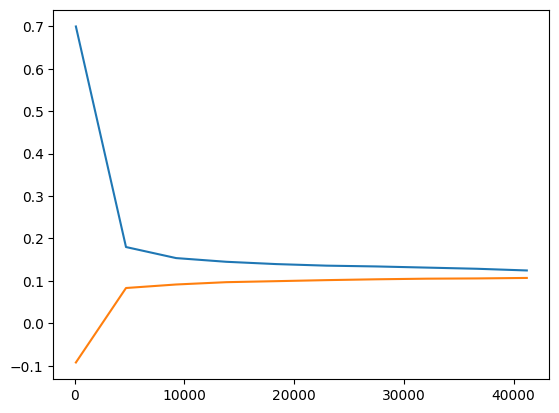

In [67]:
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')

In [167]:
# Create a CatBoostRegressor object
cat_model = CatBoostRegressor(iterations=300, learning_rate=0.1, depth = 10, loss_function='RMSE')

# Fit the model to the training data
cat_model.fit(X_train, y_train)

0:	learn: 2.6903869	total: 9.44ms	remaining: 2.82s
1:	learn: 2.5424223	total: 17.5ms	remaining: 2.6s
2:	learn: 2.4102740	total: 25.4ms	remaining: 2.52s
3:	learn: 2.2952892	total: 34ms	remaining: 2.51s
4:	learn: 2.1936009	total: 42.9ms	remaining: 2.53s
5:	learn: 2.1076592	total: 54.1ms	remaining: 2.65s
6:	learn: 2.0342776	total: 62.7ms	remaining: 2.63s
7:	learn: 1.9708679	total: 71.9ms	remaining: 2.62s
8:	learn: 1.9140915	total: 82.5ms	remaining: 2.67s
9:	learn: 1.8633407	total: 93.6ms	remaining: 2.71s
10:	learn: 1.8229169	total: 103ms	remaining: 2.7s
11:	learn: 1.7830841	total: 112ms	remaining: 2.69s
12:	learn: 1.7525593	total: 123ms	remaining: 2.72s
13:	learn: 1.7189077	total: 136ms	remaining: 2.79s
14:	learn: 1.6893920	total: 145ms	remaining: 2.76s
15:	learn: 1.6604837	total: 153ms	remaining: 2.72s
16:	learn: 1.6348030	total: 161ms	remaining: 2.69s
17:	learn: 1.6139988	total: 169ms	remaining: 2.65s
18:	learn: 1.5955314	total: 178ms	remaining: 2.63s
19:	learn: 1.5781174	total: 185ms	r

168:	learn: 0.9598797	total: 1.62s	remaining: 1.26s
169:	learn: 0.9577920	total: 1.63s	remaining: 1.25s
170:	learn: 0.9542927	total: 1.64s	remaining: 1.24s
171:	learn: 0.9524706	total: 1.65s	remaining: 1.23s
172:	learn: 0.9503561	total: 1.66s	remaining: 1.22s
173:	learn: 0.9481800	total: 1.67s	remaining: 1.21s
174:	learn: 0.9457191	total: 1.68s	remaining: 1.2s
175:	learn: 0.9429331	total: 1.69s	remaining: 1.19s
176:	learn: 0.9405174	total: 1.7s	remaining: 1.18s
177:	learn: 0.9383633	total: 1.71s	remaining: 1.17s
178:	learn: 0.9359713	total: 1.72s	remaining: 1.16s
179:	learn: 0.9343388	total: 1.73s	remaining: 1.15s
180:	learn: 0.9331682	total: 1.74s	remaining: 1.14s
181:	learn: 0.9313348	total: 1.74s	remaining: 1.13s
182:	learn: 0.9291581	total: 1.75s	remaining: 1.12s
183:	learn: 0.9277058	total: 1.76s	remaining: 1.11s
184:	learn: 0.9257920	total: 1.77s	remaining: 1.1s
185:	learn: 0.9244396	total: 1.78s	remaining: 1.09s
186:	learn: 0.9222657	total: 1.78s	remaining: 1.08s
187:	learn: 0.9

land_use_area: 26.838
veg: 16.353
height_resid: 15.581
population: 14.857
land_use_code_14100: 7.989
water: 2.978
land_use_code_12100: 2.885
height_nonresid: 2.864
land_use_code_31000: 2.270
roads: 1.542
land_use_code_11210: 1.289
land_use_code_11220: 0.966
land_use_code_50000: 0.962
land_use_code_21000: 0.878
land_use_code_14200: 0.661
land_use_code_23000: 0.265
land_use_code_32000: 0.260
land_use_code_11100: 0.135
land_use_code_11230: 0.121
land_use_code_40000: 0.106
land_use_code_13400: 0.066
land_use_code_12400: 0.063
land_use_code_12230: 0.050
land_use_code_13300: 0.009
land_use_code_12210: 0.007
land_use_code_12220: 0.002
land_use_code_11240: 0.001
land_use_code_24000: 0.001
land_use_code_13100: 0.000
land_use_code_11300: 0.000
land_use_code_12300: 0.000
land_use_code_33000: 0.000


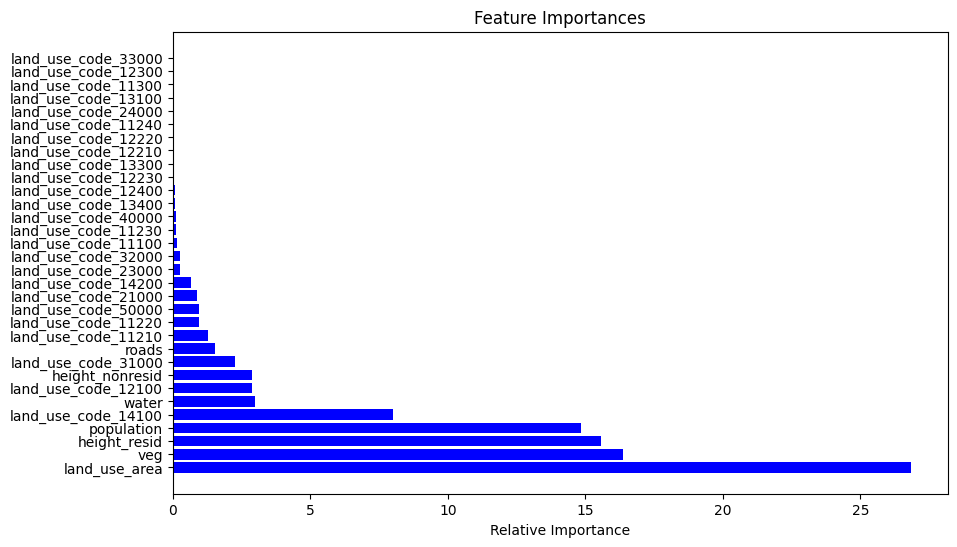

In [168]:
# Get feature importance scores
importances = cat_model.feature_importances_
features = X_train.columns

# Sort feature importance scores in descending order
indices = importances.argsort()[::-1]

# Print feature importance scores
for i in range(len(features)):
    print(f"{features[indices[i]]}: {importances[indices[i]]:.3f}")

# Plot feature importance scores
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

In [68]:
# No further improvements using more data

## XG Boost

In [70]:
! pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 4.7 MB/s eta 0:00:0000:0100:01


In [74]:
import xgboost as xgb
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

In [72]:
# Create an XGBoost model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=5, alpha=10, n_estimators=100)

# Fit the model to the training data
xg_reg.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = xg_reg.predict(X_test)

# Compute the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

MSE: 1.6288672728086016


In [75]:
r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)

R-squared: 0.1295229822343823


In [76]:
param_grid = {
    'learning_rate': [0.1, 0.01],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 200]
}

# Create an XGBoost model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3)

# Perform grid search with cross-validation to find the optimal hyperparameters
grid_search = GridSearchCV(estimator=xg_reg, param_grid=param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

# Make predictions on the testing data using the best model
y_pred = grid_search.predict(X_test)

# Compute the R-squared of the predictions
r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)

# Print the best hyperparameters found by the grid search
print('Best hyperparameters:', grid_search.best_params_)

Fitting 5 folds for each of 18 candidates, totalling 90 fits
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.091 total time=   0.4s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.094 total time=   0.4s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.094 total time=   0.4s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.082 total time=   0.4s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=50;, score=0.085 total time=   0.4s
[CV 1/5] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.102 total time=   0.6s
[CV 2/5] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.104 total time=   0.6s
[CV 3/5] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.105 total time=   0.6s
[CV 4/5] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.090 total time=   0.6s
[CV 5/5] END learning_rate=0.1, max_depth=3, n_estimators=100;, score=0.095 total time=  

[CV 2/5] END learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.073 total time=   2.4s
[CV 3/5] END learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.081 total time=   2.5s
[CV 4/5] END learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.066 total time=   2.5s
[CV 5/5] END learning_rate=0.01, max_depth=7, n_estimators=200;, score=0.074 total time=   2.4s
R-squared: 0.15935053632201157
Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}


In [77]:
# Create an XGBoost model
xg_reg = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=7, alpha=10, n_estimators=100)

# Fit the model to the training data
xg_reg.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = xg_reg.predict(X_test)

# Compute the mean squared error of the predictions
r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)

R-squared: 0.14545104374032203


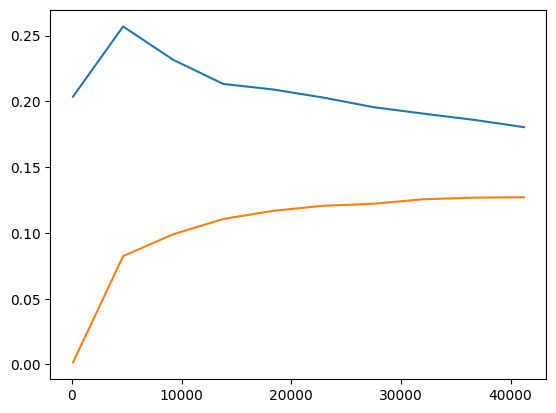

In [80]:
from sklearn.model_selection import learning_curve

train_sizes = np.arange(100, 45687, int(45687/10))

# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator=xg_reg, X=X_train, y=y_train, train_sizes=train_sizes, cv=5)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
#plt.ylabel('r2 score', fontsize = 14)
#plt.xlabel('Training set size', fontsize = 14)
#plt.title('Learning curves', fontsize = 18, y = 1.03)
#plt.legend()

land_use_code_14100: 0.548
land_use_code_31000: 0.074
land_use_code_11100: 0.045
land_use_code_12100: 0.037
land_use_code_11220: 0.037
land_use_code_12400: 0.029
land_use_area: 0.028
land_use_code_14200: 0.028
land_use_code_50000: 0.022
veg: 0.020
land_use_code_21000: 0.017
land_use_code_11210: 0.014
water: 0.014
land_use_code_32000: 0.013
land_use_code_23000: 0.010
land_use_code_12210: 0.009
population: 0.008
height_resid: 0.008
height_nonresid: 0.006
land_use_code_11300: 0.006
land_use_code_40000: 0.005
land_use_code_11230: 0.005
land_use_code_13300: 0.004
roads: 0.003
land_use_code_12230: 0.003
land_use_code_12220: 0.002
land_use_code_13400: 0.002
land_use_code_13100: 0.001
land_use_code_24000: 0.001
land_use_code_12300: 0.001
land_use_code_11240: 0.001
land_use_code_33000: 0.000


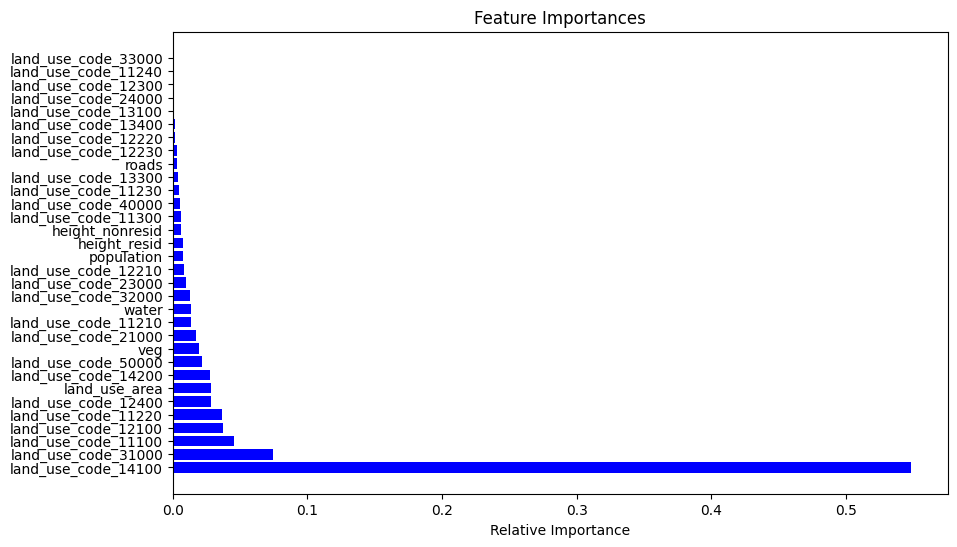

In [165]:
# Get feature importance scores
importances = xg_reg.feature_importances_
features = X_train.columns

# Sort feature importance scores in descending order
indices = importances.argsort()[::-1]

# Print feature importance scores
for i in range(len(features)):
    print(f"{features[indices[i]]}: {importances[indices[i]]:.3f}")

# Plot feature importance scores
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## Random Forest

In [82]:
from sklearn.ensemble import RandomForestRegressor

In [83]:
# Create a random forest model
rf_reg = RandomForestRegressor(n_estimators=100, max_depth=5, random_state=42)

# Fit the model to the training data
rf_reg.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = rf_reg.predict(X_test)

# Compute the R-squared of the predictions
r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)

/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


R-squared: 0.11228289093114607


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [84]:
# Define the hyperparameter grid to search over
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [3, 5, 7]
}

# Perform grid search with cross-validation to find the optimal hyperparameters
grid_search = GridSearchCV(estimator=rf_reg, param_grid=param_grid, cv=5, verbose=3)
grid_search.fit(X_train, y_train)

# Make predictions on the testing data using the best model
y_pred = grid_search.predict(X_test)

r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)

# Print the best hyperparameters found by the grid search
print('Best hyperparameters:', grid_search.best_params_)

Fitting 5 folds for each of 9 candidates, totalling 45 fits


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 1/5] END ......max_depth=3, n_estimators=50;, score=0.078 total time=   1.5s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 2/5] END ......max_depth=3, n_estimators=50;, score=0.084 total time=   1.6s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 3/5] END ......max_depth=3, n_estimators=50;, score=0.073 total time=   1.5s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 4/5] END ......max_depth=3, n_estimators=50;, score=0.066 total time=   1.6s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 5/5] END ......max_depth=3, n_estimators=50;, score=0.074 total time=   1.7s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 1/5] END .....max_depth=3, n_estimators=100;, score=0.078 total time=   3.5s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 2/5] END .....max_depth=3, n_estimators=100;, score=0.084 total time=   3.7s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 3/5] END .....max_depth=3, n_estimators=100;, score=0.073 total time=   3.9s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 4/5] END .....max_depth=3, n_estimators=100;, score=0.067 total time=   3.4s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 5/5] END .....max_depth=3, n_estimators=100;, score=0.074 total time=   3.5s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 1/5] END .....max_depth=3, n_estimators=200;, score=0.079 total time=   7.5s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 2/5] END .....max_depth=3, n_estimators=200;, score=0.084 total time=   6.6s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 3/5] END .....max_depth=3, n_estimators=200;, score=0.074 total time=   6.5s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 4/5] END .....max_depth=3, n_estimators=200;, score=0.067 total time=   6.3s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 5/5] END .....max_depth=3, n_estimators=200;, score=0.075 total time=   6.3s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 1/5] END ......max_depth=5, n_estimators=50;, score=0.102 total time=   2.9s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 2/5] END ......max_depth=5, n_estimators=50;, score=0.109 total time=   2.7s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 3/5] END ......max_depth=5, n_estimators=50;, score=0.101 total time=   2.8s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 4/5] END ......max_depth=5, n_estimators=50;, score=0.084 total time=   2.7s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 5/5] END ......max_depth=5, n_estimators=50;, score=0.096 total time=   2.5s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 1/5] END .....max_depth=5, n_estimators=100;, score=0.102 total time=   5.5s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 2/5] END .....max_depth=5, n_estimators=100;, score=0.108 total time=   4.9s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 3/5] END .....max_depth=5, n_estimators=100;, score=0.102 total time=   4.7s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 4/5] END .....max_depth=5, n_estimators=100;, score=0.084 total time=   4.9s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 5/5] END .....max_depth=5, n_estimators=100;, score=0.097 total time=   5.1s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 1/5] END .....max_depth=5, n_estimators=200;, score=0.103 total time=   9.5s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 2/5] END .....max_depth=5, n_estimators=200;, score=0.109 total time=   9.5s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 3/5] END .....max_depth=5, n_estimators=200;, score=0.102 total time=   9.4s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 4/5] END .....max_depth=5, n_estimators=200;, score=0.084 total time=   9.1s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 5/5] END .....max_depth=5, n_estimators=200;, score=0.097 total time=   9.2s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 1/5] END ......max_depth=7, n_estimators=50;, score=0.117 total time=   2.9s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 2/5] END ......max_depth=7, n_estimators=50;, score=0.122 total time=   3.4s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 3/5] END ......max_depth=7, n_estimators=50;, score=0.118 total time=   2.9s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 4/5] END ......max_depth=7, n_estimators=50;, score=0.105 total time=   2.9s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 5/5] END ......max_depth=7, n_estimators=50;, score=0.110 total time=   2.9s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 1/5] END .....max_depth=7, n_estimators=100;, score=0.117 total time=   5.6s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 2/5] END .....max_depth=7, n_estimators=100;, score=0.123 total time=   5.8s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 3/5] END .....max_depth=7, n_estimators=100;, score=0.118 total time=   5.7s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 4/5] END .....max_depth=7, n_estimators=100;, score=0.105 total time=   5.9s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 5/5] END .....max_depth=7, n_estimators=100;, score=0.111 total time=   5.9s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 1/5] END .....max_depth=7, n_estimators=200;, score=0.117 total time=  11.5s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 2/5] END .....max_depth=7, n_estimators=200;, score=0.124 total time=  11.1s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 3/5] END .....max_depth=7, n_estimators=200;, score=0.119 total time=  11.0s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 4/5] END .....max_depth=7, n_estimators=200;, score=0.106 total time=  10.9s


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


[CV 5/5] END .....max_depth=7, n_estimators=200;, score=0.111 total time=  10.9s
R-squared: 0.13161954740181303
Best hyperparameters: {'max_depth': 7, 'n_estimators': 200}


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse column

/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse column

/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse column

/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse column

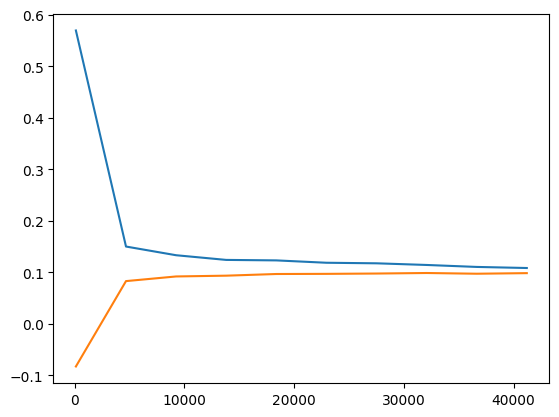

In [100]:
from sklearn.model_selection import learning_curve

train_sizes = np.arange(100, 45687, int(45687/10))

# Get train scores (R2), train sizes, and validation scores using `learning_curve`
train_sizes, train_scores, test_scores = learning_curve(
    estimator=rf_reg, X=X_train, y=y_train, train_sizes=train_sizes, cv=5)

# Take the mean of cross-validated train scores and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
plt.plot(train_sizes, train_scores_mean, label = 'Training score')
plt.plot(train_sizes, test_scores_mean, label = 'Test score')
#plt.ylabel('r2 score', fontsize = 14)
#plt.xlabel('Training set size', fontsize = 14)
#plt.title('Learning curves', fontsize = 18, y = 1.03)
#plt.legend()

## Using Bins

In [110]:
y_bin = pd.cut(y, bins=10)

In [114]:
! pip install imblearn

Defaulting to user installation because normal site-packages is not writeable
  Using cached imblearn-0.0-py2.py3-none-any.whl (1.9 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 226.0/226.0 kB 1.5 MB/s eta 0:00:00a 0:00:01


In [133]:
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder
from sklearn.datasets import make_classification

In [124]:
# Convert the target variable to categorical using LabelEncoder
le = LabelEncoder()
y_bin = le.fit_transform(y_bin)

In [134]:
y_bin.shape

(71387,)

In [136]:
pd.DataFrame(y_bin).value_counts()/y_bin.shape[0]

0    0.644641
1    0.227520
2    0.092174
3    0.026209
4    0.006584
5    0.001933
6    0.000686
7    0.000182
8    0.000042
9    0.000028
dtype: float64

In [125]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, y_bin, test_size=0.2, random_state=42)

In [137]:
from imblearn.over_sampling import RandomOverSampler
ros = RandomOverSampler(random_state=0)
X_resampled, y_resampled = ros.fit_resample(X_train, y_train)

/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/utils/validation.py:768: UserWarning: pandas.DataFrame with sparse columns found.It will be converted to a dense numpy array.
  warnings.warn(


In [146]:
X_train = X_resampled
y_train = y_resampled

In [156]:
X_train_sample = X_train.sample(n=10000, random_state=42)
y_train_sample = pd.DataFrame(y_train).sample(n=10000, random_state=42)

In [159]:
X_train = X_train_sample
y_train = y_train_sample

In [158]:
pd.DataFrame(y_train_sample).value_counts()

8    1028
4    1021
5    1016
6    1013
2     995
1     992
0     988
7     988
3     983
9     976
dtype: int64

In [164]:
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, make_scorer
from imblearn.over_sampling import RandomOverSampler
from imblearn.metrics import classification_report_imbalanced

# Define the models and their hyperparameters
models = {
    'XG Boost': {
        'model': XGBClassifier(),
        'params': {
            'max_depth': [7, 10],
            'n_estimators': [100, 200],
            'learning_rate': [0.3, 0.5],
            'gamma': [0.5]
        }
    },
    'Catboost': {
        'model': CatBoostClassifier(verbose=False),
        'params': {
            'depth': [5, 7],
            'learning_rate': [0.01, 0.1],
            'l2_leaf_reg': [5, 7]
        }
    }
}

# Define the scoring metric
scorer = make_scorer(accuracy_score)

# Perform the grid search and store the results in a dictionary
results = {}
for name, model in models.items():
    clf = model['model']
    grid = GridSearchCV(clf, model['params'], cv=5, scoring=scorer, n_jobs=-1)
    grid.fit(X_train, y_train)
    y_pred = grid.predict(X_test)
    report = classification_report_imbalanced(y_test, y_pred)
    results[name] = {
        'best_params': grid.best_params_,
        'best_score': grid.best_score_,
        'test_score': accuracy_score(y_test, y_pred),
        'classification_report': report
    }

# Print the results
for name, result in results.items():
    print(name)
    print(f"Best params: {result['best_params']}")
    print(f"Best score: {result['best_score']}")
    print(f"Test score: {result['test_score']}")
    print(f"Classification report:\n{result['classification_report']}\n")

/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


XG Boost
Best params: {'gamma': 0.5, 'learning_rate': 0.5, 'max_depth': 10, 'n_estimators': 100}
Best score: 0.732
Test score: 0.3536909931362936
Classification report:
                   pre       rec       spe        f1       geo       iba       sup

          0       0.75      0.40      0.75      0.52      0.55      0.29      9244
          1       0.25      0.28      0.76      0.27      0.46      0.20      3238
          2       0.11      0.23      0.82      0.15      0.44      0.18      1260
          3       0.06      0.28      0.87      0.10      0.49      0.23       388
          4       0.02      0.18      0.94      0.04      0.41      0.15       102
          5       0.01      0.09      0.98      0.02      0.29      0.08        34
          6       0.00      0.00      0.99      0.00      0.00      0.00         8
          7       0.00      0.00      1.00      0.00      0.00      0.00         2
          8       0.00      0.00      1.00      0.00      0.00      0.00         2


/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/basilemorel/Library/Python/3.9/lib/python/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Sensitivity is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


### Feature Importance

land_use_code_14100: 0.186
land_use_code_32000: 0.123
water: 0.104
land_use_code_31000: 0.089
land_use_code_50000: 0.073
veg: 0.041
land_use_code_12100: 0.035
land_use_code_23000: 0.032
land_use_area: 0.031
land_use_code_11220: 0.029
land_use_code_40000: 0.027
height_resid: 0.026
land_use_code_11210: 0.024
height_nonresid: 0.019
land_use_code_12230: 0.019
population: 0.019
land_use_code_21000: 0.018
roads: 0.018
land_use_code_11230: 0.016
land_use_code_11100: 0.016
land_use_code_13400: 0.015
land_use_code_14200: 0.012
land_use_code_12210: 0.009
land_use_code_12300: 0.006
land_use_code_12400: 0.004
land_use_code_12220: 0.004
land_use_code_13300: 0.003
land_use_code_13100: 0.001
land_use_code_11240: 0.000
land_use_code_33000: 0.000
land_use_code_24000: 0.000
land_use_code_11300: 0.000


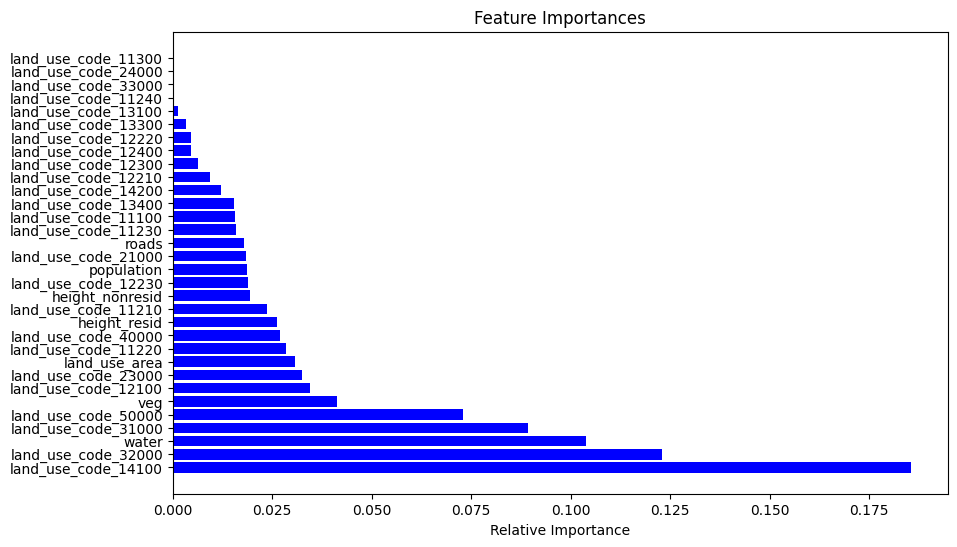

In [170]:
# Create a CatBoostRegressor object
xg_cla = XGBClassifier(max_depth = 10, n_estimators = 100, learning_rate = 0.5, gamma = 0.5)

# Fit the model to the training data
xg_cla.fit(X_train_sample, y_train_sample)

# Get feature importance scores
importances = xg_cla.feature_importances_
features = X_train_sample.columns

# Sort feature importance scores in descending order
indices = importances.argsort()[::-1]

# Print feature importance scores
for i in range(len(features)):
    print(f"{features[indices[i]]}: {importances[indices[i]]:.3f}")

# Plot feature importance scores
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

0:	learn: 2.1004871	total: 13.6ms	remaining: 13.6s
1:	learn: 1.9945815	total: 25.3ms	remaining: 12.6s
2:	learn: 1.9094979	total: 37.8ms	remaining: 12.6s
3:	learn: 1.8432610	total: 49.4ms	remaining: 12.3s
4:	learn: 1.7857334	total: 62ms	remaining: 12.3s
5:	learn: 1.7339117	total: 79.3ms	remaining: 13.1s
6:	learn: 1.6894093	total: 94.9ms	remaining: 13.5s
7:	learn: 1.6572663	total: 107ms	remaining: 13.2s
8:	learn: 1.6224988	total: 119ms	remaining: 13.1s
9:	learn: 1.5932941	total: 130ms	remaining: 12.9s
10:	learn: 1.5710827	total: 143ms	remaining: 12.9s
11:	learn: 1.5464884	total: 155ms	remaining: 12.7s
12:	learn: 1.5262724	total: 166ms	remaining: 12.6s
13:	learn: 1.5075910	total: 176ms	remaining: 12.4s
14:	learn: 1.4902714	total: 187ms	remaining: 12.3s
15:	learn: 1.4687600	total: 198ms	remaining: 12.2s
16:	learn: 1.4491784	total: 209ms	remaining: 12.1s
17:	learn: 1.4355471	total: 222ms	remaining: 12.1s
18:	learn: 1.4217429	total: 233ms	remaining: 12.1s
19:	learn: 1.4073780	total: 249ms	re

176:	learn: 0.8919261	total: 2.5s	remaining: 11.7s
177:	learn: 0.8906986	total: 2.52s	remaining: 11.6s
178:	learn: 0.8897790	total: 2.53s	remaining: 11.6s
179:	learn: 0.8892547	total: 2.54s	remaining: 11.6s
180:	learn: 0.8883955	total: 2.56s	remaining: 11.6s
181:	learn: 0.8870884	total: 2.58s	remaining: 11.6s
182:	learn: 0.8863708	total: 2.59s	remaining: 11.6s
183:	learn: 0.8860510	total: 2.6s	remaining: 11.5s
184:	learn: 0.8849272	total: 2.62s	remaining: 11.5s
185:	learn: 0.8842177	total: 2.63s	remaining: 11.5s
186:	learn: 0.8828958	total: 2.64s	remaining: 11.5s
187:	learn: 0.8816947	total: 2.66s	remaining: 11.5s
188:	learn: 0.8804048	total: 2.67s	remaining: 11.5s
189:	learn: 0.8792687	total: 2.69s	remaining: 11.4s
190:	learn: 0.8774990	total: 2.7s	remaining: 11.4s
191:	learn: 0.8763478	total: 2.71s	remaining: 11.4s
192:	learn: 0.8749205	total: 2.73s	remaining: 11.4s
193:	learn: 0.8738606	total: 2.74s	remaining: 11.4s
194:	learn: 0.8726829	total: 2.76s	remaining: 11.4s
195:	learn: 0.8

341:	learn: 0.7477562	total: 4.76s	remaining: 9.17s
342:	learn: 0.7475104	total: 4.78s	remaining: 9.16s
343:	learn: 0.7467951	total: 4.79s	remaining: 9.14s
344:	learn: 0.7457652	total: 4.81s	remaining: 9.14s
345:	learn: 0.7453893	total: 4.83s	remaining: 9.13s
346:	learn: 0.7446754	total: 4.84s	remaining: 9.11s
347:	learn: 0.7433689	total: 4.85s	remaining: 9.09s
348:	learn: 0.7428778	total: 4.86s	remaining: 9.07s
349:	learn: 0.7418909	total: 4.88s	remaining: 9.05s
350:	learn: 0.7418595	total: 4.89s	remaining: 9.04s
351:	learn: 0.7409550	total: 4.9s	remaining: 9.03s
352:	learn: 0.7405809	total: 4.91s	remaining: 9.01s
353:	learn: 0.7405554	total: 4.93s	remaining: 8.99s
354:	learn: 0.7397964	total: 4.94s	remaining: 8.97s
355:	learn: 0.7394763	total: 4.95s	remaining: 8.95s
356:	learn: 0.7390409	total: 4.96s	remaining: 8.93s
357:	learn: 0.7388030	total: 4.97s	remaining: 8.92s
358:	learn: 0.7381708	total: 4.99s	remaining: 8.9s
359:	learn: 0.7377296	total: 5s	remaining: 8.88s
360:	learn: 0.737

512:	learn: 0.6556504	total: 7.01s	remaining: 6.65s
513:	learn: 0.6553135	total: 7.02s	remaining: 6.64s
514:	learn: 0.6549249	total: 7.03s	remaining: 6.62s
515:	learn: 0.6542394	total: 7.04s	remaining: 6.61s
516:	learn: 0.6538343	total: 7.06s	remaining: 6.59s
517:	learn: 0.6535262	total: 7.07s	remaining: 6.58s
518:	learn: 0.6534975	total: 7.08s	remaining: 6.56s
519:	learn: 0.6528907	total: 7.09s	remaining: 6.54s
520:	learn: 0.6525406	total: 7.1s	remaining: 6.53s
521:	learn: 0.6521834	total: 7.11s	remaining: 6.51s
522:	learn: 0.6515809	total: 7.12s	remaining: 6.5s
523:	learn: 0.6512336	total: 7.13s	remaining: 6.48s
524:	learn: 0.6508046	total: 7.14s	remaining: 6.46s
525:	learn: 0.6507242	total: 7.15s	remaining: 6.45s
526:	learn: 0.6504681	total: 7.16s	remaining: 6.43s
527:	learn: 0.6502545	total: 7.17s	remaining: 6.41s
528:	learn: 0.6495899	total: 7.18s	remaining: 6.4s
529:	learn: 0.6494182	total: 7.2s	remaining: 6.38s
530:	learn: 0.6491703	total: 7.21s	remaining: 6.37s
531:	learn: 0.64

685:	learn: 0.5862769	total: 9.08s	remaining: 4.16s
686:	learn: 0.5861827	total: 9.1s	remaining: 4.14s
687:	learn: 0.5857183	total: 9.11s	remaining: 4.13s
688:	learn: 0.5853606	total: 9.13s	remaining: 4.12s
689:	learn: 0.5851434	total: 9.15s	remaining: 4.11s
690:	learn: 0.5848399	total: 9.16s	remaining: 4.1s
691:	learn: 0.5847511	total: 9.18s	remaining: 4.09s
692:	learn: 0.5844441	total: 9.2s	remaining: 4.07s
693:	learn: 0.5841008	total: 9.22s	remaining: 4.06s
694:	learn: 0.5835253	total: 9.23s	remaining: 4.05s
695:	learn: 0.5833608	total: 9.25s	remaining: 4.04s
696:	learn: 0.5831399	total: 9.26s	remaining: 4.03s
697:	learn: 0.5829507	total: 9.28s	remaining: 4.01s
698:	learn: 0.5827286	total: 9.29s	remaining: 4s
699:	learn: 0.5822618	total: 9.31s	remaining: 3.99s
700:	learn: 0.5820186	total: 9.32s	remaining: 3.98s
701:	learn: 0.5813965	total: 9.33s	remaining: 3.96s
702:	learn: 0.5811264	total: 9.35s	remaining: 3.95s
703:	learn: 0.5808603	total: 9.36s	remaining: 3.93s
704:	learn: 0.5803

845:	learn: 0.5378962	total: 10.9s	remaining: 1.99s
846:	learn: 0.5377210	total: 11s	remaining: 1.98s
847:	learn: 0.5374554	total: 11s	remaining: 1.97s
848:	learn: 0.5372534	total: 11s	remaining: 1.95s
849:	learn: 0.5369370	total: 11s	remaining: 1.94s
850:	learn: 0.5367018	total: 11s	remaining: 1.93s
851:	learn: 0.5364822	total: 11s	remaining: 1.91s
852:	learn: 0.5362697	total: 11s	remaining: 1.9s
853:	learn: 0.5361401	total: 11s	remaining: 1.89s
854:	learn: 0.5359098	total: 11.1s	remaining: 1.88s
855:	learn: 0.5353100	total: 11.1s	remaining: 1.86s
856:	learn: 0.5351279	total: 11.1s	remaining: 1.85s
857:	learn: 0.5346473	total: 11.1s	remaining: 1.84s
858:	learn: 0.5342610	total: 11.1s	remaining: 1.82s
859:	learn: 0.5339461	total: 11.1s	remaining: 1.81s
860:	learn: 0.5338184	total: 11.1s	remaining: 1.8s
861:	learn: 0.5335301	total: 11.2s	remaining: 1.79s
862:	learn: 0.5333015	total: 11.2s	remaining: 1.77s
863:	learn: 0.5330838	total: 11.2s	remaining: 1.76s
864:	learn: 0.5328098	total: 1

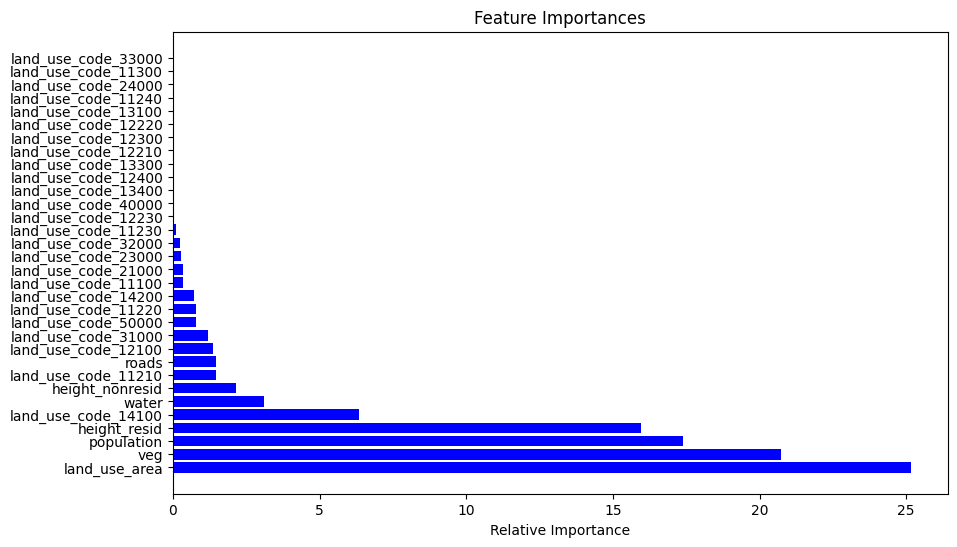

In [172]:
# Create a CatBoostRegressor object
cat_cla = CatBoostClassifier(depth = 7, l2_leaf_reg = 5, learning_rate = 0.1)

# Fit the model to the training data
cat_cla.fit(X_train_sample, y_train_sample)

# Get feature importance scores
importances = cat_cla.feature_importances_
features = X_train_sample.columns

# Sort feature importance scores in descending order
indices = importances.argsort()[::-1]

# Print feature importance scores
for i in range(len(features)):
    print(f"{features[indices[i]]}: {importances[indices[i]]:.3f}")

# Plot feature importance scores
plt.figure(figsize=(10, 6))
plt.title("Feature Importances")
plt.barh(range(len(indices)), importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel("Relative Importance")
plt.show()

## Prediction

In [173]:
# Best: XG Boost Regressor
# R-squared: 0.15935053632201157
# Best hyperparameters: {'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 200}

In [191]:
X_train, X_test, y_train, y_test = train_test_split(X_encoded, df['log_y'], test_size=0.2, random_state=42)

In [192]:
# Create an XGBoost model
xg_reg_best = xgb.XGBRegressor(objective='reg:squarederror', colsample_bytree=0.3, learning_rate=0.1,
                          max_depth=7, alpha=10, n_estimators=200)

# Fit the model to the training data
xg_reg_best.fit(X_train, y_train)

# Make predictions on the testing data
y_pred = xg_reg_best.predict(X_test)

# Compute the mean squared error of the predictions
mse = mean_squared_error(y_test, y_pred)
print('MSE:', mse)

r2 = r2_score(y_test, y_pred)
print('R-squared:', r2)

MSE: 1.5764184545043716
R-squared: 0.15755196391075588


In [177]:
X_test.columns

Index(['veg', 'roads', 'water', 'height_resid', 'height_nonresid',
       'land_use_area', 'population', 'land_use_code_11100',
       'land_use_code_11210', 'land_use_code_11220', 'land_use_code_11230',
       'land_use_code_11240', 'land_use_code_11300', 'land_use_code_12100',
       'land_use_code_12210', 'land_use_code_12220', 'land_use_code_12230',
       'land_use_code_12300', 'land_use_code_12400', 'land_use_code_13100',
       'land_use_code_13300', 'land_use_code_13400', 'land_use_code_14100',
       'land_use_code_14200', 'land_use_code_21000', 'land_use_code_23000',
       'land_use_code_24000', 'land_use_code_31000', 'land_use_code_32000',
       'land_use_code_33000', 'land_use_code_40000', 'land_use_code_50000'],
      dtype='object')

In [184]:
observation = X_test.iloc[2]

In [187]:
observation = pd.DataFrame(observation).T

In [188]:
xg_reg_best.predict(pd.DataFrame(observation))

array([-0.6098378], dtype=float32)